<a href="https://colab.research.google.com/github/taceroc/light_echo_modeling/blob/main/projected_points_sphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


from astropy.coordinates import (cartesian_to_spherical, SkyCoord, Distance, Galactic, EarthLocation, AltAz, CartesianRepresentation, SphericalRepresentation)
from astropy import units as u
# Calculate observer's local sidereal time (LST)
from astropy.time import Time
from astropy.coordinates import EarthLocation

%config InlineBackend.figure_format='retina'

In [2]:
def scatter_phase_function(g = 0, scatter_angle = np.pi / 2):
  mu =  np.cos(scatter_angle)
  return ((1 - g**2) / (1 + g**2  - 2 * g * mu)**(3/2) ) / 4 * np.pi

In [3]:
Deltat = 200 # days
dtoy = 0.00273973 # 1 day = 0.00273973 y
Deltat_y = np.array(Deltat) * dtoy
r0 = [0.10, 0.30, 1.0] # pc
pctoly = 3.26156 # 1pc = 3.26156 light-year
r0ly = np.array(r0) * pctoly
# -- point where the plane-parallel slab of dust intersects the line of sight
# -- inclination of the plane, is perpendicular to the line of sight (I am using 89 so the tangent don't die)
# alpha = 20 * np.pi/180  # angle of tilt in radians
# a = np.tan(alpha)
dt0 = 50 * dtoy
dz0 = 0.02 * pctoly # in ly

c = 1 # in light-year / year
ct = Deltat * dtoy
pctom = 3.086e+16 # pc to meter
n = 2.3 * (100 ** 3) #m-3
n = n * ( pctom ** 3 ) / ( pctoly ** 3 )
sigma = 5e-22 / (100 ** 2) #m2 #RR paper
sigma = ( sigma / ( (pctom ** 2) ) ) * ( pctoly ** 2 )
albedo = 0.6
Fphi = scatter_phase_function()
print(Fphi, 1/4 * np.pi)
# -- distance source - observer
dkpc = 5 #kpc
d = dkpc * 1000 * pctoly

k = sigma * albedo * Fphi
# L = 15,000 x 3.9e26 # watts = kg m ^2 / s^3
L = (15000 * 3.9e36) * ((60 * 60 * 24 * 365) ** 3) * (pctoly ** 2) / (pctom ** 2)
Ir = k * L * c / (4 * np.pi * (dkpc * 1000 * pctoly)**2)

0.7853981633974483 0.7853981633974483


In [4]:
# import sympy as sym
# from sympy import cos, sin
# from sympy import *

In [5]:
# x = sym.Symbol('x')
# y = sym.Symbol('y')
# t = sym.Symbol('t')
# delta = sym.Symbol('delta')

In [6]:
# simplify(sym.solveset(((x**2 + y**2 - (t)**2)**2 * (cos(delta)**2 - 1)) + ( cos(delta)**2 * ((2 * t)**2 * (x**2 + y**2))), y))


Solution for

$cos \delta = \frac{z}{\sqrt{x^2 + y^2 + z^2}}$,

$z \rightarrow x^2 + y^2 = (ct)^2 + 2zct \rightarrow$ from paraboloid.

There are 4 solutions for y

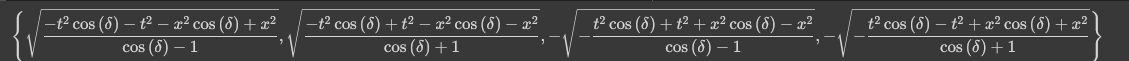

In [7]:
ct**2, 2*r0ly*ct

(0.300244818916, array([0.35743175, 1.07229525, 3.57431751]))

In [8]:
r_le2 = 2 * r0ly * ct - (ct)**2
r_le = np.sqrt(r_le2)
r_le

array([0.23913789, 0.87866401, 1.80943988])

In [9]:
x = np.linspace(-10,10,100)
# y = np.linspace(-r_le, r_le, 100)

In [10]:
def calc_intersection_xz(x, delta, r0ly, ct):
  """
    Calculate the intersection points x,z between the plane and the paraboloid

    Arguments:
      x: initialize values for x, e.g: x = np.linspace(-10, 10, 1000) in ly
      delta: angle(s) where the dust is valid in deg
      r0ly: plane intersects the line of sight here in ly
      a: inclination of the plane a = tan(alpha)
      ct: time where the LE is observed
  """


  r_le2 = 2 * r0ly * ct - (ct)**2
  r_le = np.sqrt(r_le2)
  # x = np.linspace(-10, 10, 1000)
  # -- arccos(z / r) >> y =
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )


  y_inv = np.array((y_inv1, y_inv2, y_inv3, y_inv4))
  # print("y", y_inv)

  x_inter_inv = np.sqrt(r_le2 - y_inv**2)
  x_inter_inv_n = -1*x_inter_inv

  x_inter = np.hstack((x_inter_inv, x_inter_inv_n))

  # -- keep nonan values
  x_inter_nan_values = x_inter[~np.isnan(x_inter)]
  # x_inter_nan_values = x_inter[~np.isnan(x_inter)]
  # print("x_inter", x_inter_nan_values)

  ys = np.concatenate((y_inv[~np.isnan(x_inter_inv)], y_inv[~np.isnan(x_inter_inv_n)]))
  # print("ys", ys)

  z_inter_non = np.sqrt(r0ly**2 - ys**2 - x_inter_nan_values**2)
  # print("zs", z_inter_non)


  return x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv#, y_inv_n

In [11]:
def dust(delta, x_inter_nan_values, z_inter_non, n_h):
  np.random.seed(52+int(delta))
  grid = np.random.uniform(0, 1, (len(x_inter_nan_values), len(z_inter_non)))
  # -- data cube with 3 dimension 0: x values, 1: z values, 2: value of the density in that x,z in the projected plane
  data_cube = np.zeros((len(x_inter_nan_values), len(z_inter_non), 3))

  for i in range(len(x_inter_nan_values)):
      for j in range(len(z_inter_non)):
        if i == j:
          data_cube[i, i, 0] = x_inter_nan_values[i]
          data_cube[i, i, 1] = z_inter_non[i]
          data_cube[i, i, 2] = grid[i, i] * n_h
        else:
          data_cube[i, j, 0] = x_inter_nan_values[i]
          data_cube[i, j, 1] = z_inter_non[j]
          data_cube[i, j, 2] = 0

  return data_cube

In [12]:
def surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, Ir, dz0, dt0, r0ly):
  # angle = np.linspace(0, 2 * np.pi, 1000)
  r = np.sqrt(2 * z_inter_non * ct + (ct)**2  + z_inter_non**2)#z_inter_non + ct
  # print(z_inter_non)
  # -- rho = x^2 + y^2 = r_le
  # rhodrho  = (dz0 * ct) + (r0ly * c * dt0) + ct * dt0 * (1 + a**2)
  rhodrho =  (dz0 * ct) + (z_inter_non * c * dt0) + c * ct * dt0
  # print(rhodrho)


  surface = np.zeros(len(r))
  for ff in range(len(x_inter_nan_values)):
      surface[ff] = Ir * data_cube[ff, ff, 2] * dz0 / ( 4 * np.pi * r[ff] * rhodrho[ff] )

  return surface

In [13]:
def rinout(y_inv, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le):
  x_inter = np.concatenate((x_inter_inv, x_inter_inv_n))
  ys = np.concatenate((y_inv[~np.isnan(x_inter_inv)], y_inv[~np.isnan(x_inter_inv_n)]))
  phis = np.arctan2(ys, x_inter[~np.isnan(x_inter)])

  half_obs_thickness = np.sqrt( (ct / r_le) ** 2 * dz0 ** 2 + ( (r_le * c / 2 * ct) + ( c * ct / 2 * r_le )) ** 2 * dt0  ** 2 ) / 2
  # -- include the thickness in xy plane
  r_le_out= r_le + half_obs_thickness
  # -- in arcseconds 5kpc = 16308 ly
  # -- degree to arcseconds
  r_le_out = np.arctan(r_le_out / d) * (180 / np.pi) * 3600
  r_le_in = r_le - half_obs_thickness
  r_le_in = np.arctan(r_le_in / d) * (180 / np.pi) * 3600

  # act = np.arctan(a * ct / d) * (180 / np.pi) * 3600


  return phis, r_le_out, r_le_in

In [14]:
r0ly[2]

3.26156

In [15]:
def final_xy_projected(phis, r_le_out, r_le_in):
    radii_p = [r_le_out, r_le_in]
    xs_p = np.outer(radii_p, np.cos(phis))
    ys_p = np.outer(radii_p, np.sin(phis))


    new_xs = xs_p.reshape(1,2,len(phis))
    new_ys = ys_p.reshape(1,2,len(phis))

    return new_xs, new_ys#, new_xs_h, new_ys_h

In [16]:
def LE_xy_surface_concate(r0ly, ct, deltass, x):
  r_le2 = 2 * r0ly * ct - (ct)**2
  r_le = np.sqrt(r_le2)

  new_xs_list = []
  new_ys_list = []

  surface_list = []

  # deltass = np.linspace(0, 360, 400)
  for deltas in deltass:
    x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv = calc_intersection_xz(x, deltas, r0ly, ct)
    data_cube = dust(deltas, x_inter_nan_values, z_inter_non, n_h = n)
    surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, Ir, dz0, dt0, r0ly)
    phis, r_le_out, r_le_in = rinout(y_inv, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
    new_xs, new_ys = final_xy_projected(phis, r_le_out, r_le_in)

    new_xs_list.append(new_xs)
    new_ys_list.append(new_ys)
    surface_list.append(surface)

  new_xs = np.concatenate(new_xs_list, axis = 2)
  new_ys = np.concatenate(new_ys_list, axis = 2)

  surface = np.concatenate(surface_list)


  return new_xs, new_ys, surface


def plot(new_xs, new_ys, surface, deltass, save = False, name = "name"):
  fig, ax = plt.subplots(1, 1, figsize=(12, 8))


  surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
  cmap = matplotlib.colormaps.get_cmap('magma_r')
  normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



  ax.set_title("density define only for %s degrees"%([deltass.min(), deltass.max()]))

  # r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600

  mins = np.min((new_xs, new_ys))
  maxs = np.max((new_xs, new_ys))
  stdmin = np.min((np.std(new_xs), np.std(new_ys)))
  stdmax = np.max((np.std(new_xs), np.std(new_ys)))


  ax.set_xlim(mins - stdmin, maxs + stdmax)
  ax.set_ylim(mins - stdmin, maxs + stdmax)

  for k in range(len(surface)):
    ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))

  # ax.scatter(- act, 0, marker = "*", color = "purple")
  ax.scatter(0, 0, marker = "*", color = "crimson")


  cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

  ax.set_xlabel("arcsec")
  ax.set_ylabel("arcsec")
  ax.set_box_aspect(1)

  cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
  cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

  def label_cbrt(x,pos):
      return "{:.1f}".format(x)

  cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
  # cb.update_ticks()
  # plt.tight_layout()

  if save == True:
    plt.savefig(name+".png", dpi = 700, bbox_inches='tight')


<ipython-input-10-1114441001c9>:18: RuntimeWarning: divide by zero encountered in divide
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: divide by zero encountered in divide
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid

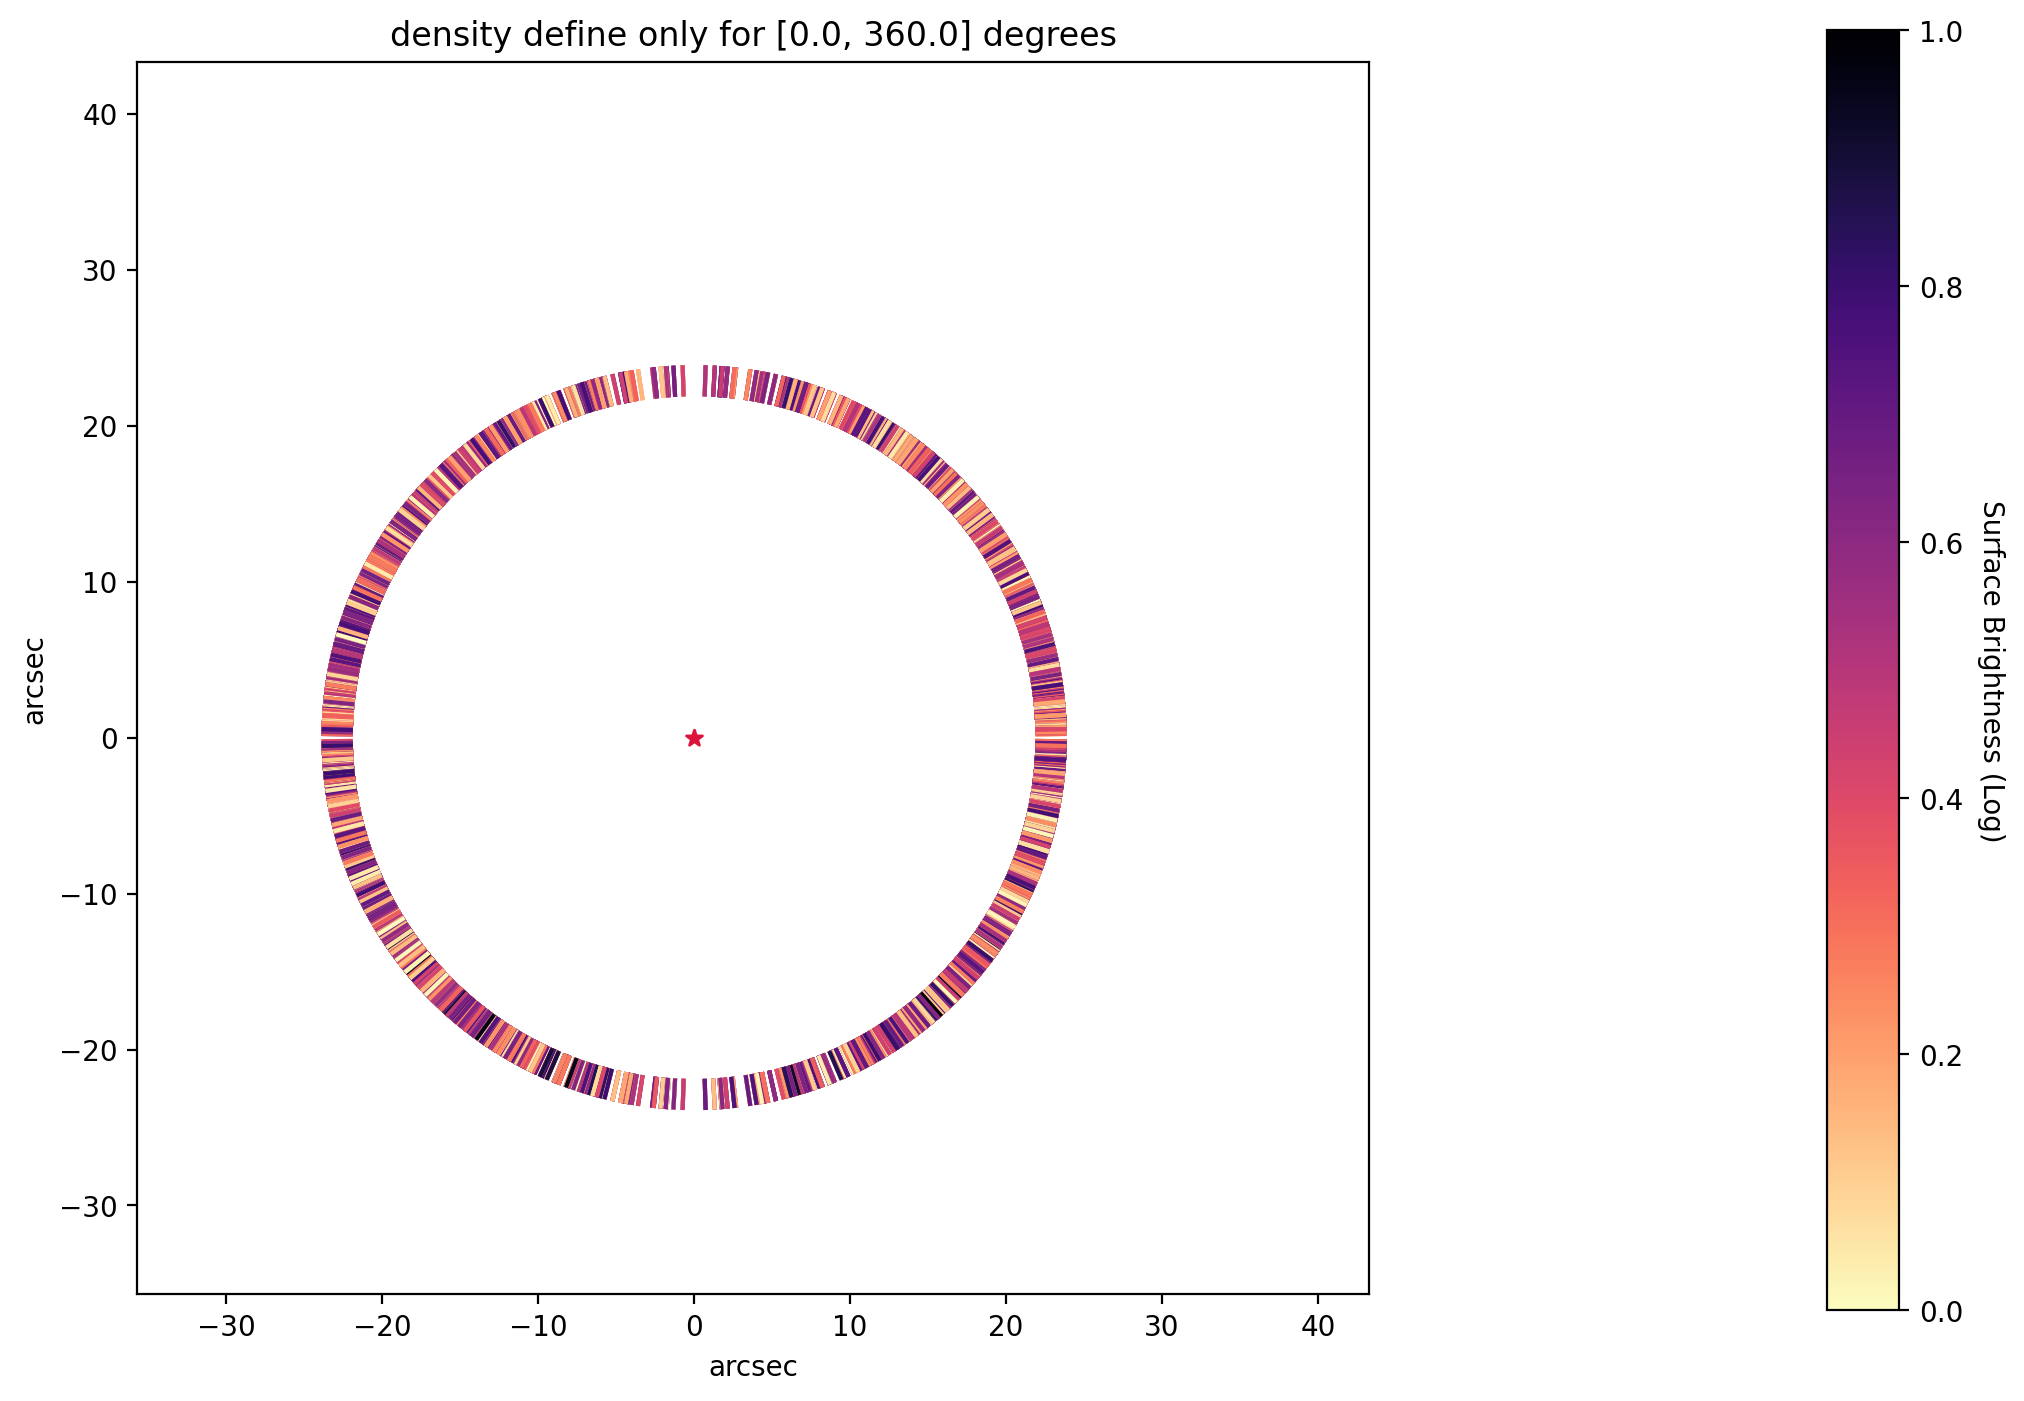

In [17]:
deltass = np.linspace(0, 360, 400)
new_xs, new_ys, surface = LE_xy_surface_concate(r0ly[2], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )
<ipython-input-10-1114441001c9>:27: RuntimeWarning: invalid va

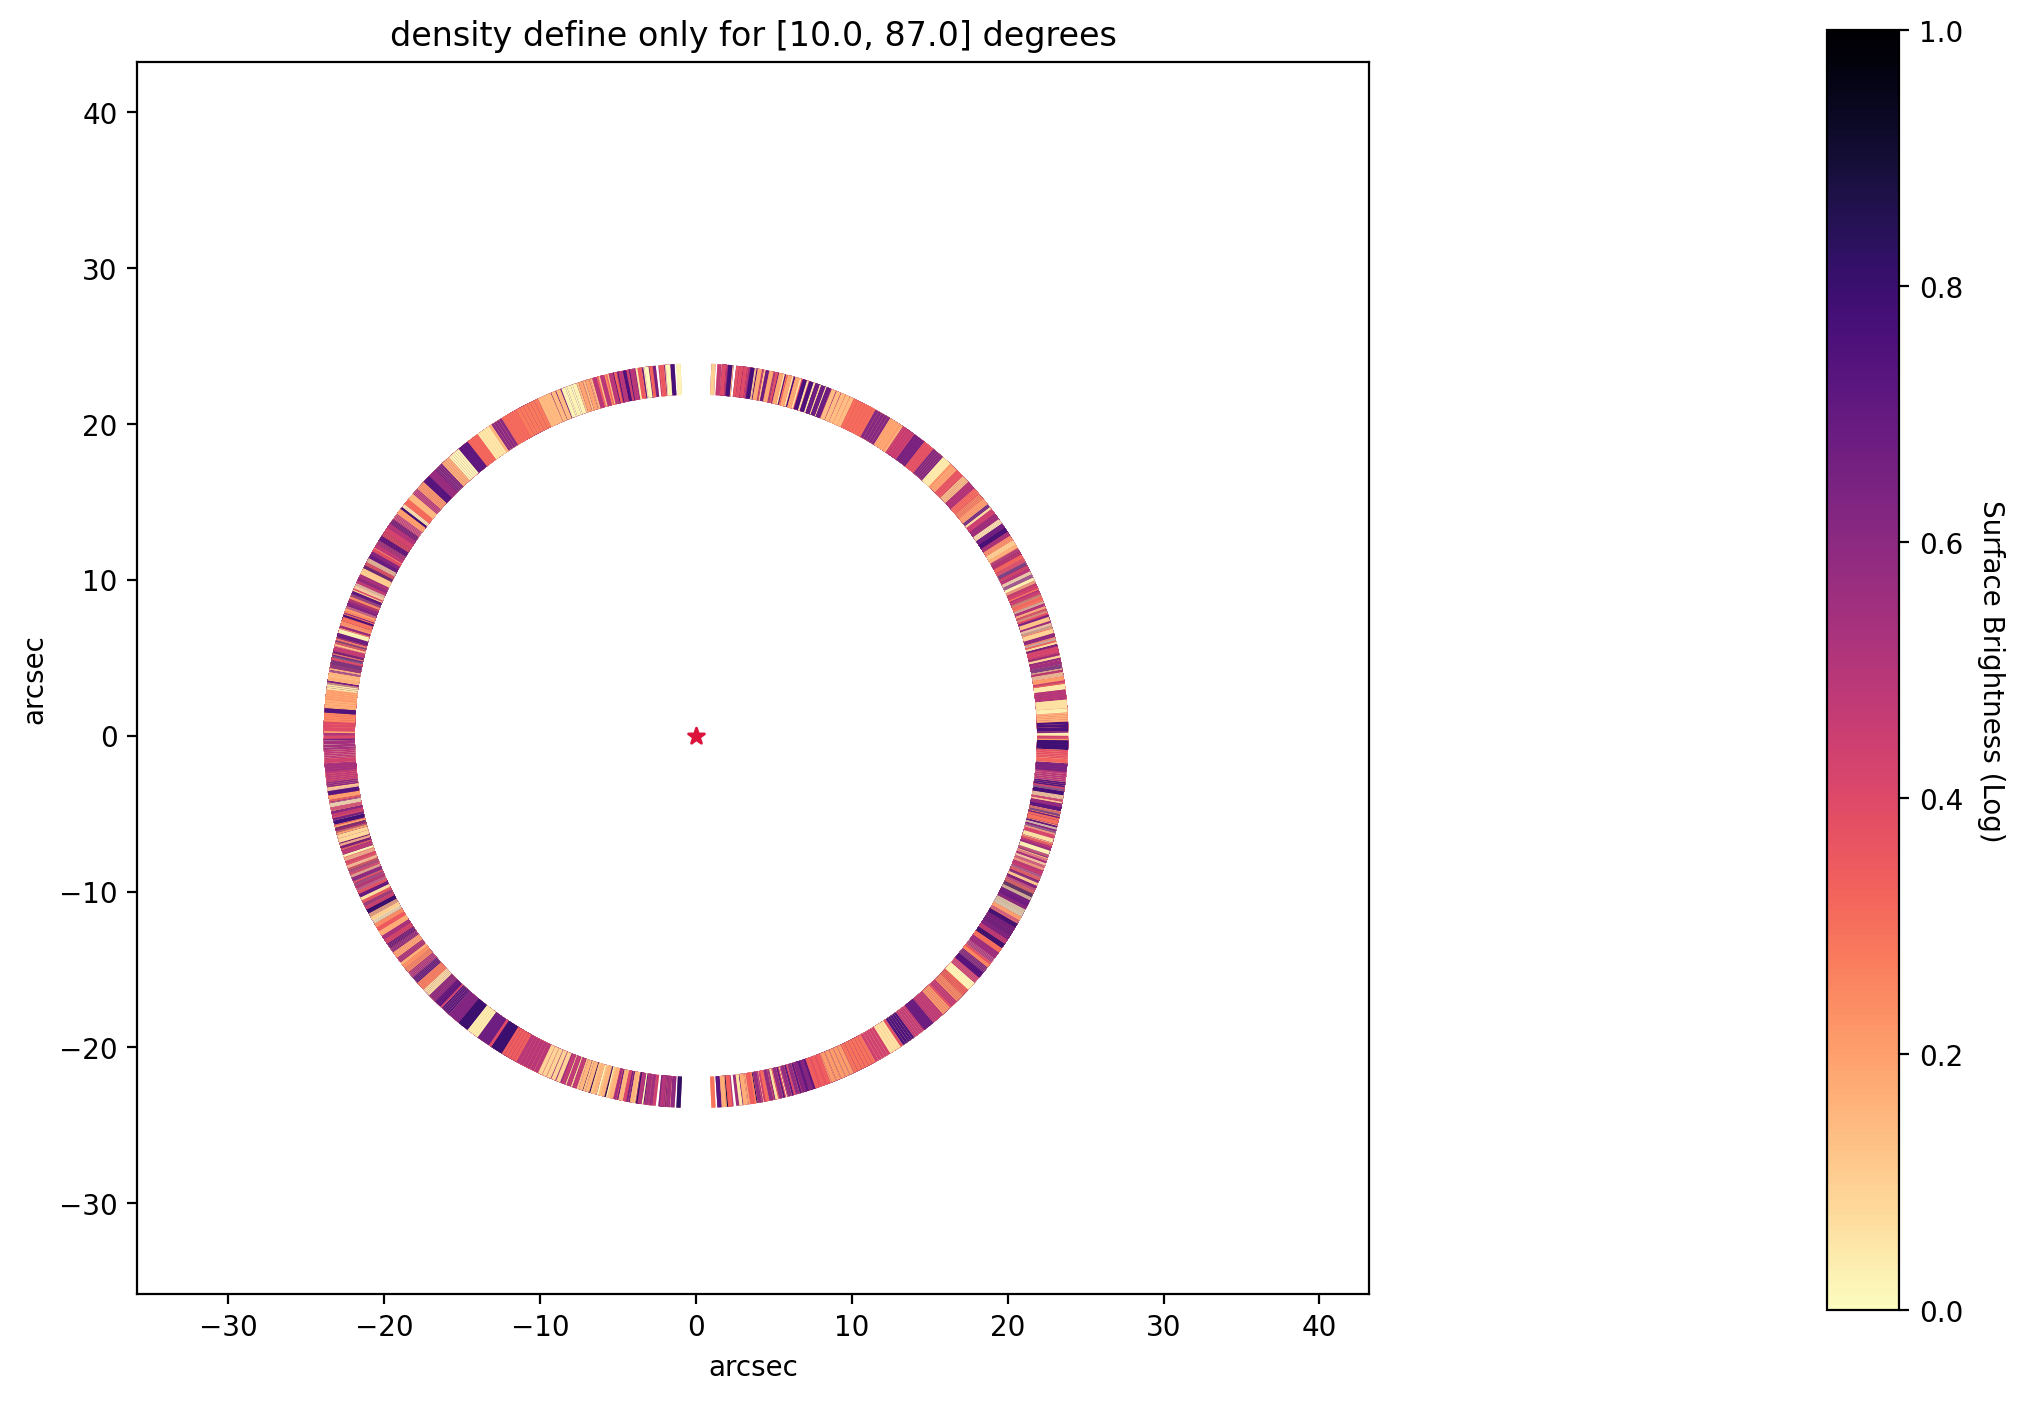

In [18]:
deltass = np.linspace(10, 87, 400)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[2], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )
<ipython-input-10-1114441001c9>:27: RuntimeWarning: invalid va

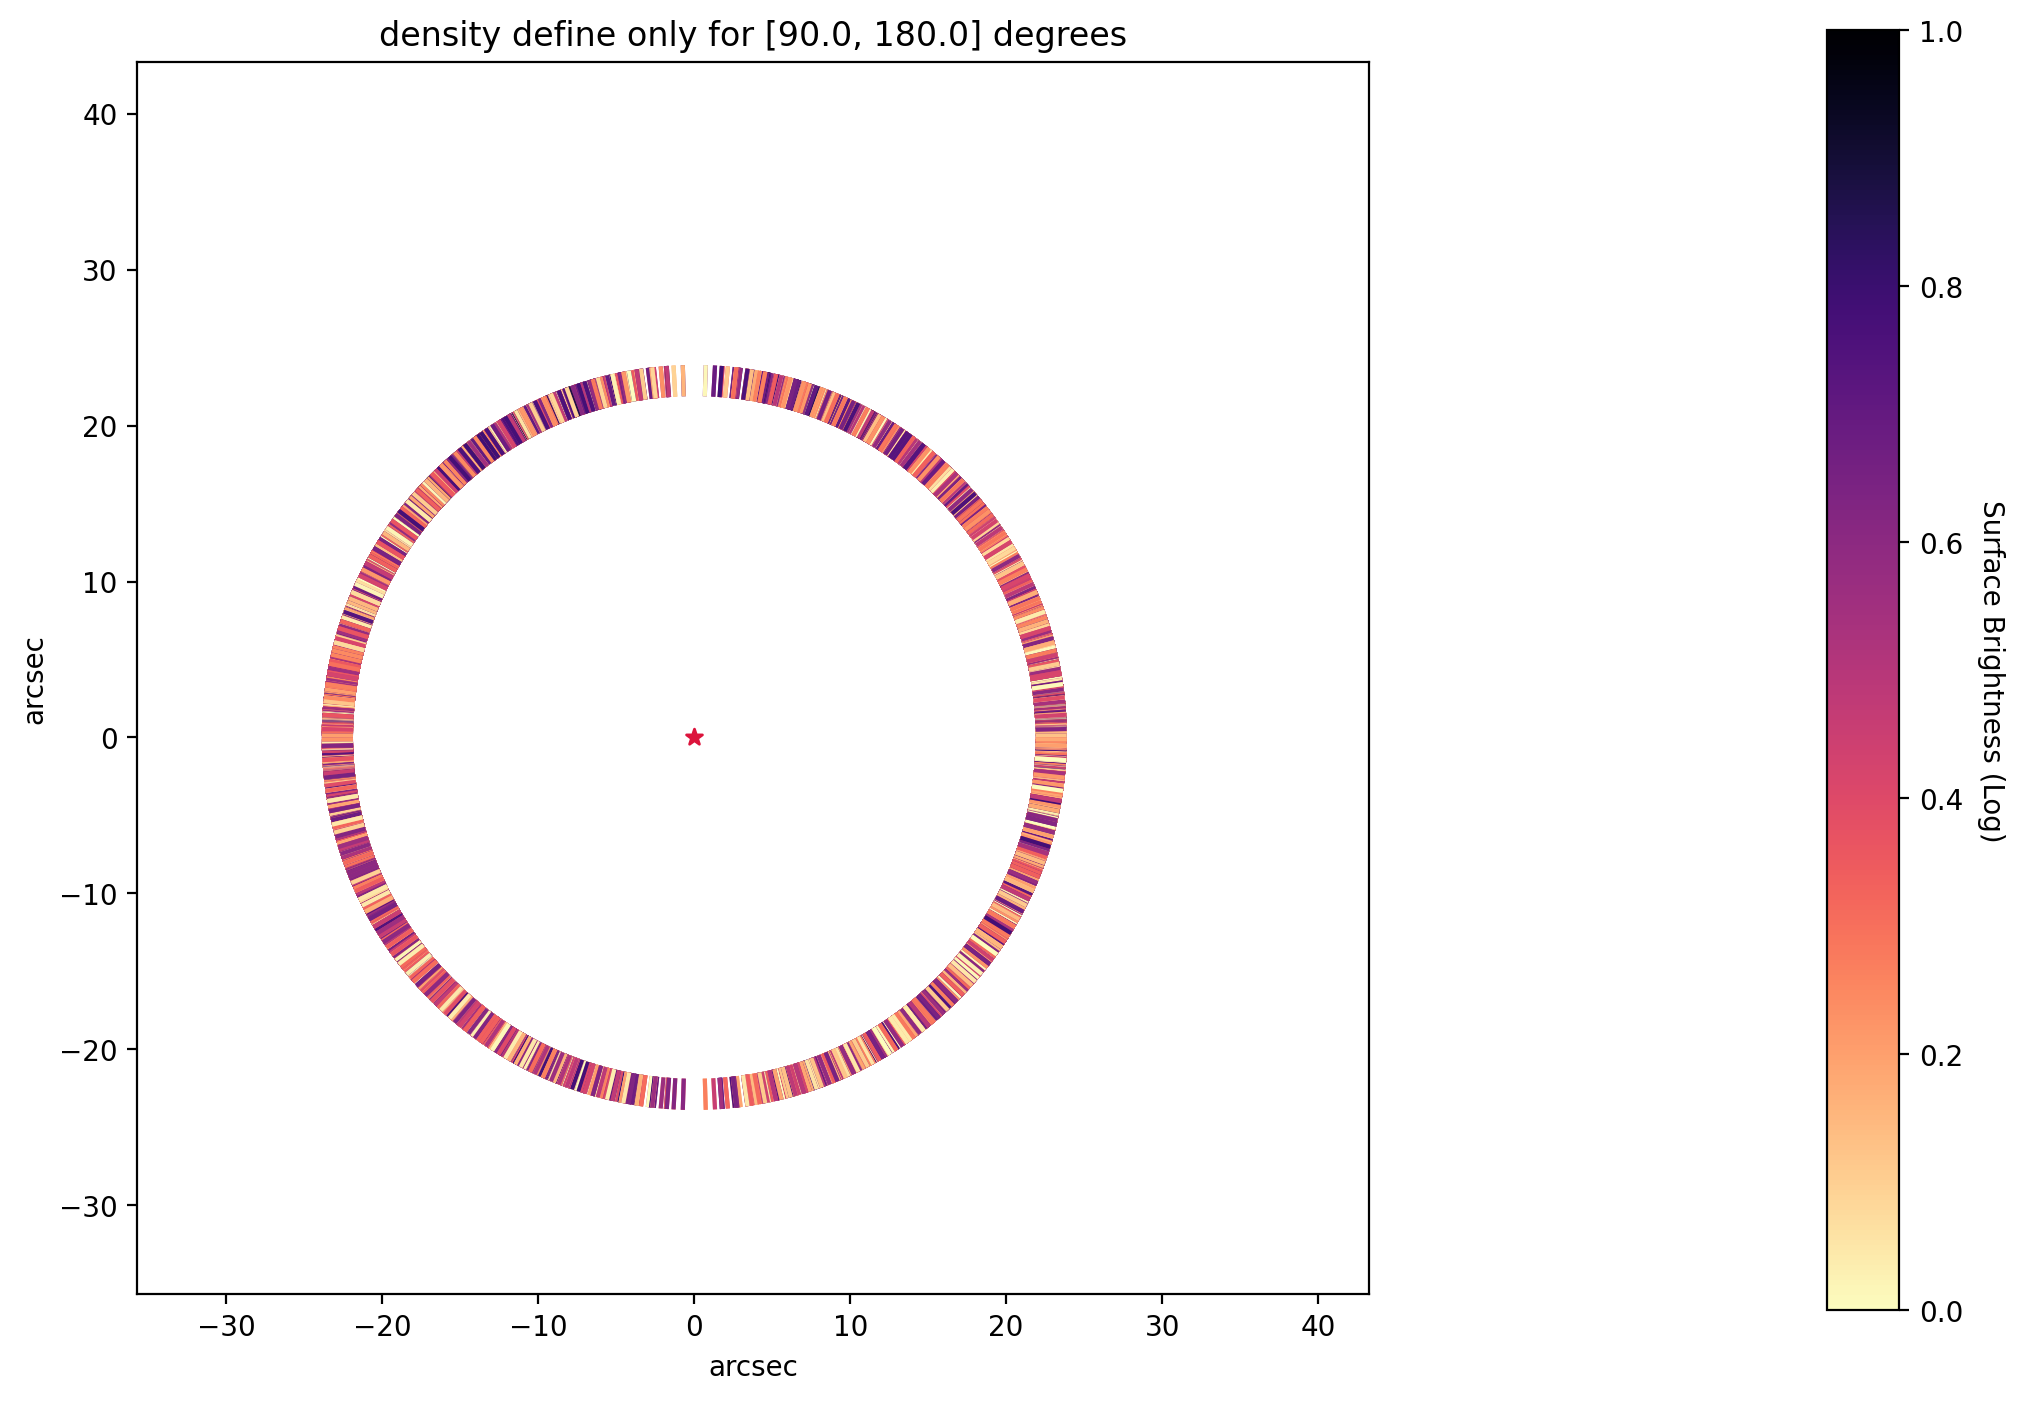

In [19]:
deltass = np.linspace(90, 180, 400)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[2], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )


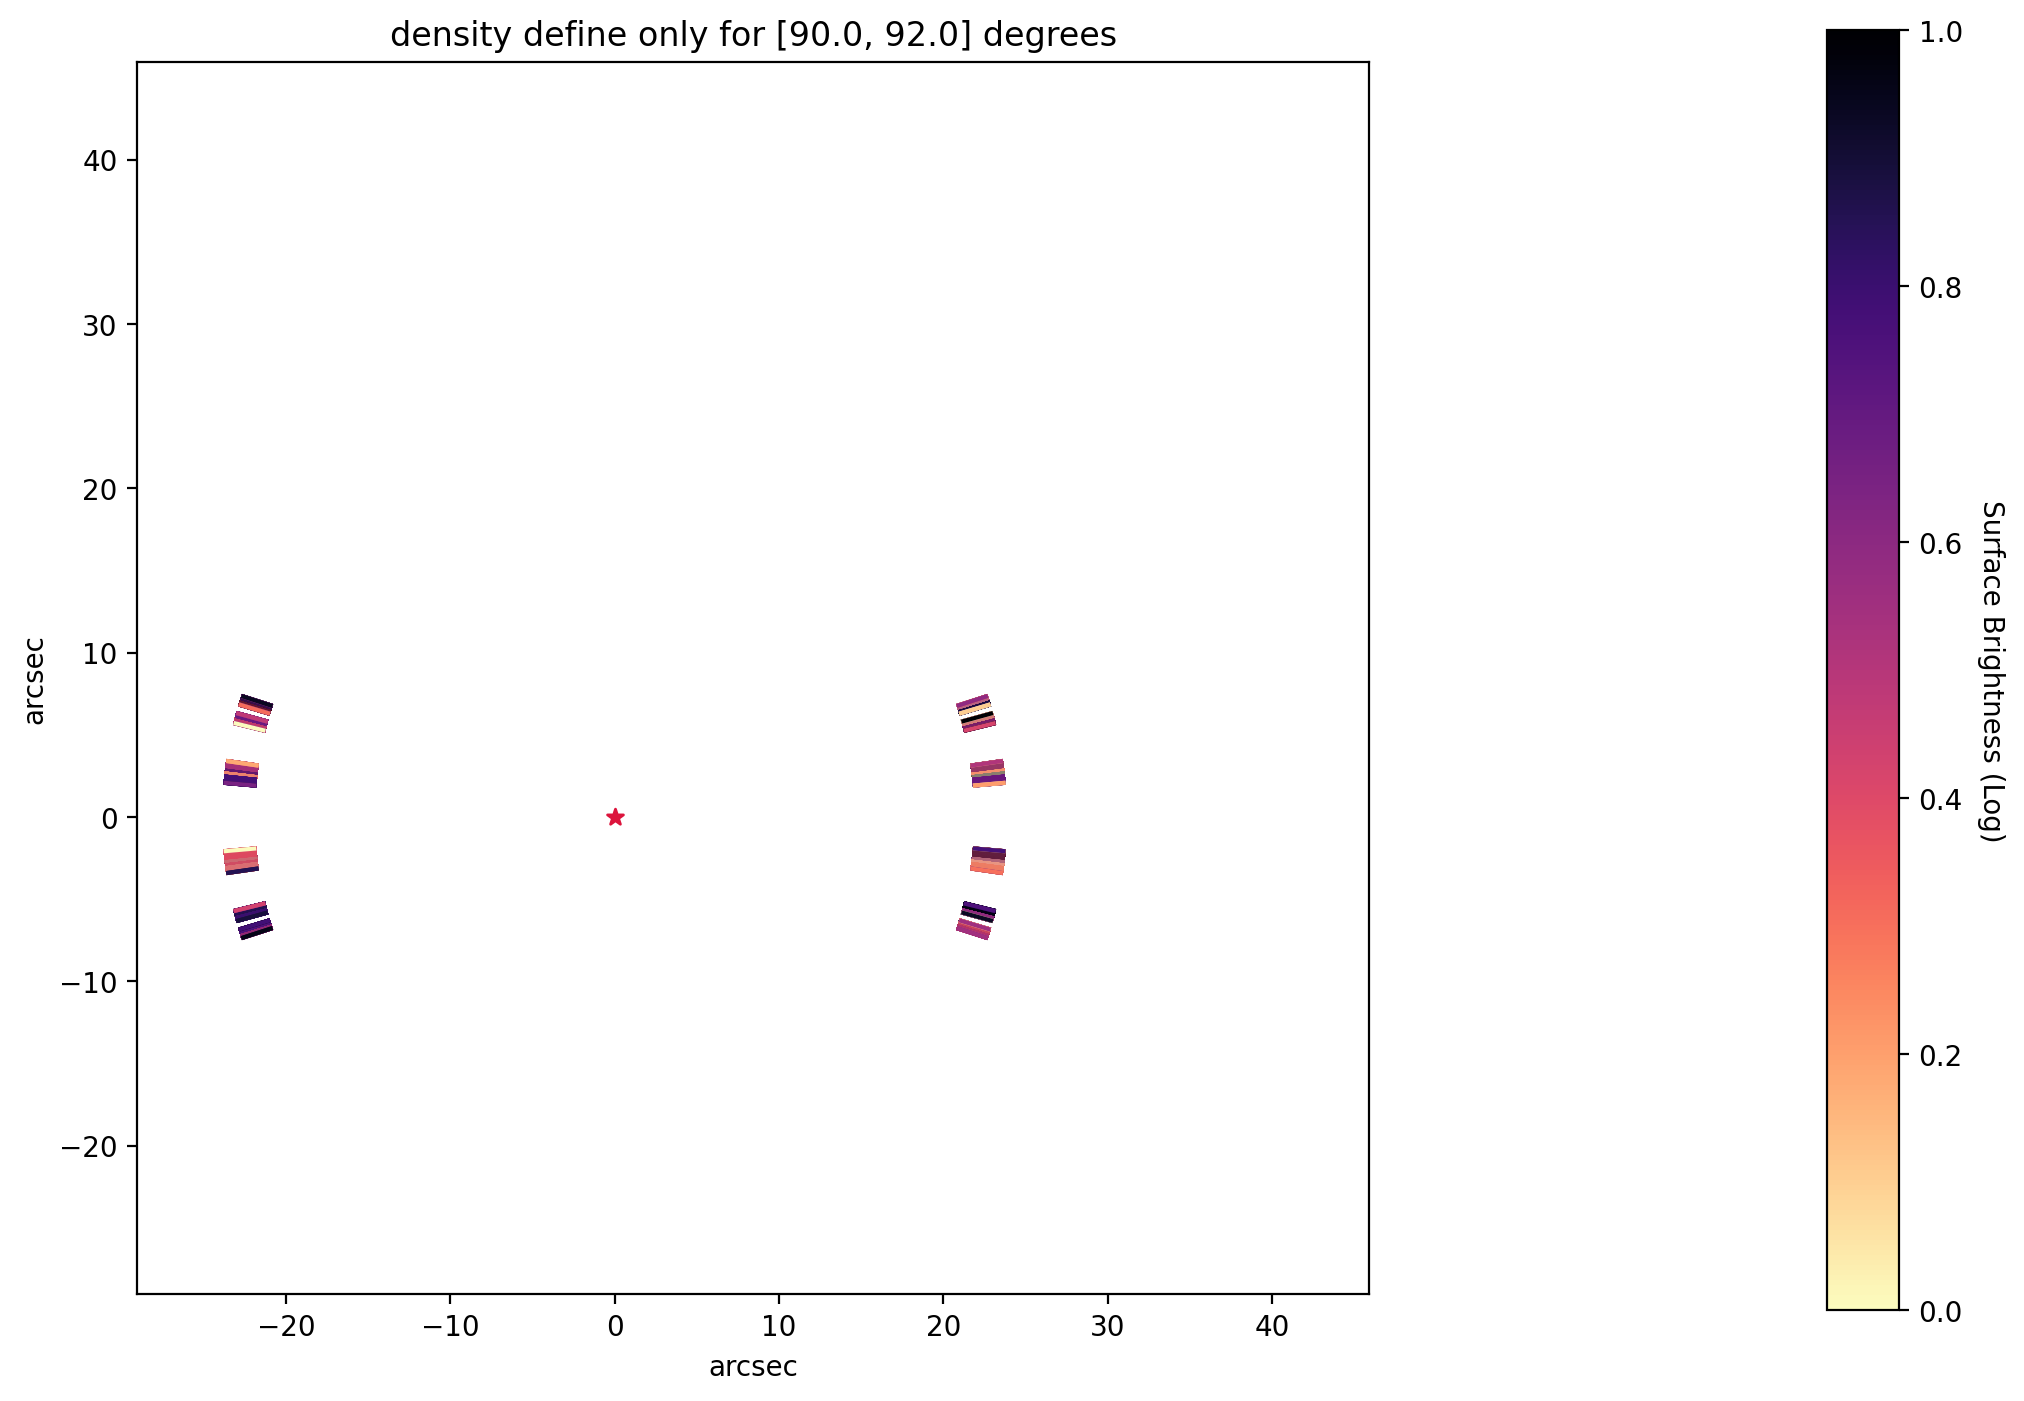

In [20]:
deltass = np.linspace(90, 92, 400)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[2], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )
<ipython-input-10-1114441001c9>:27: RuntimeWarning: invalid va

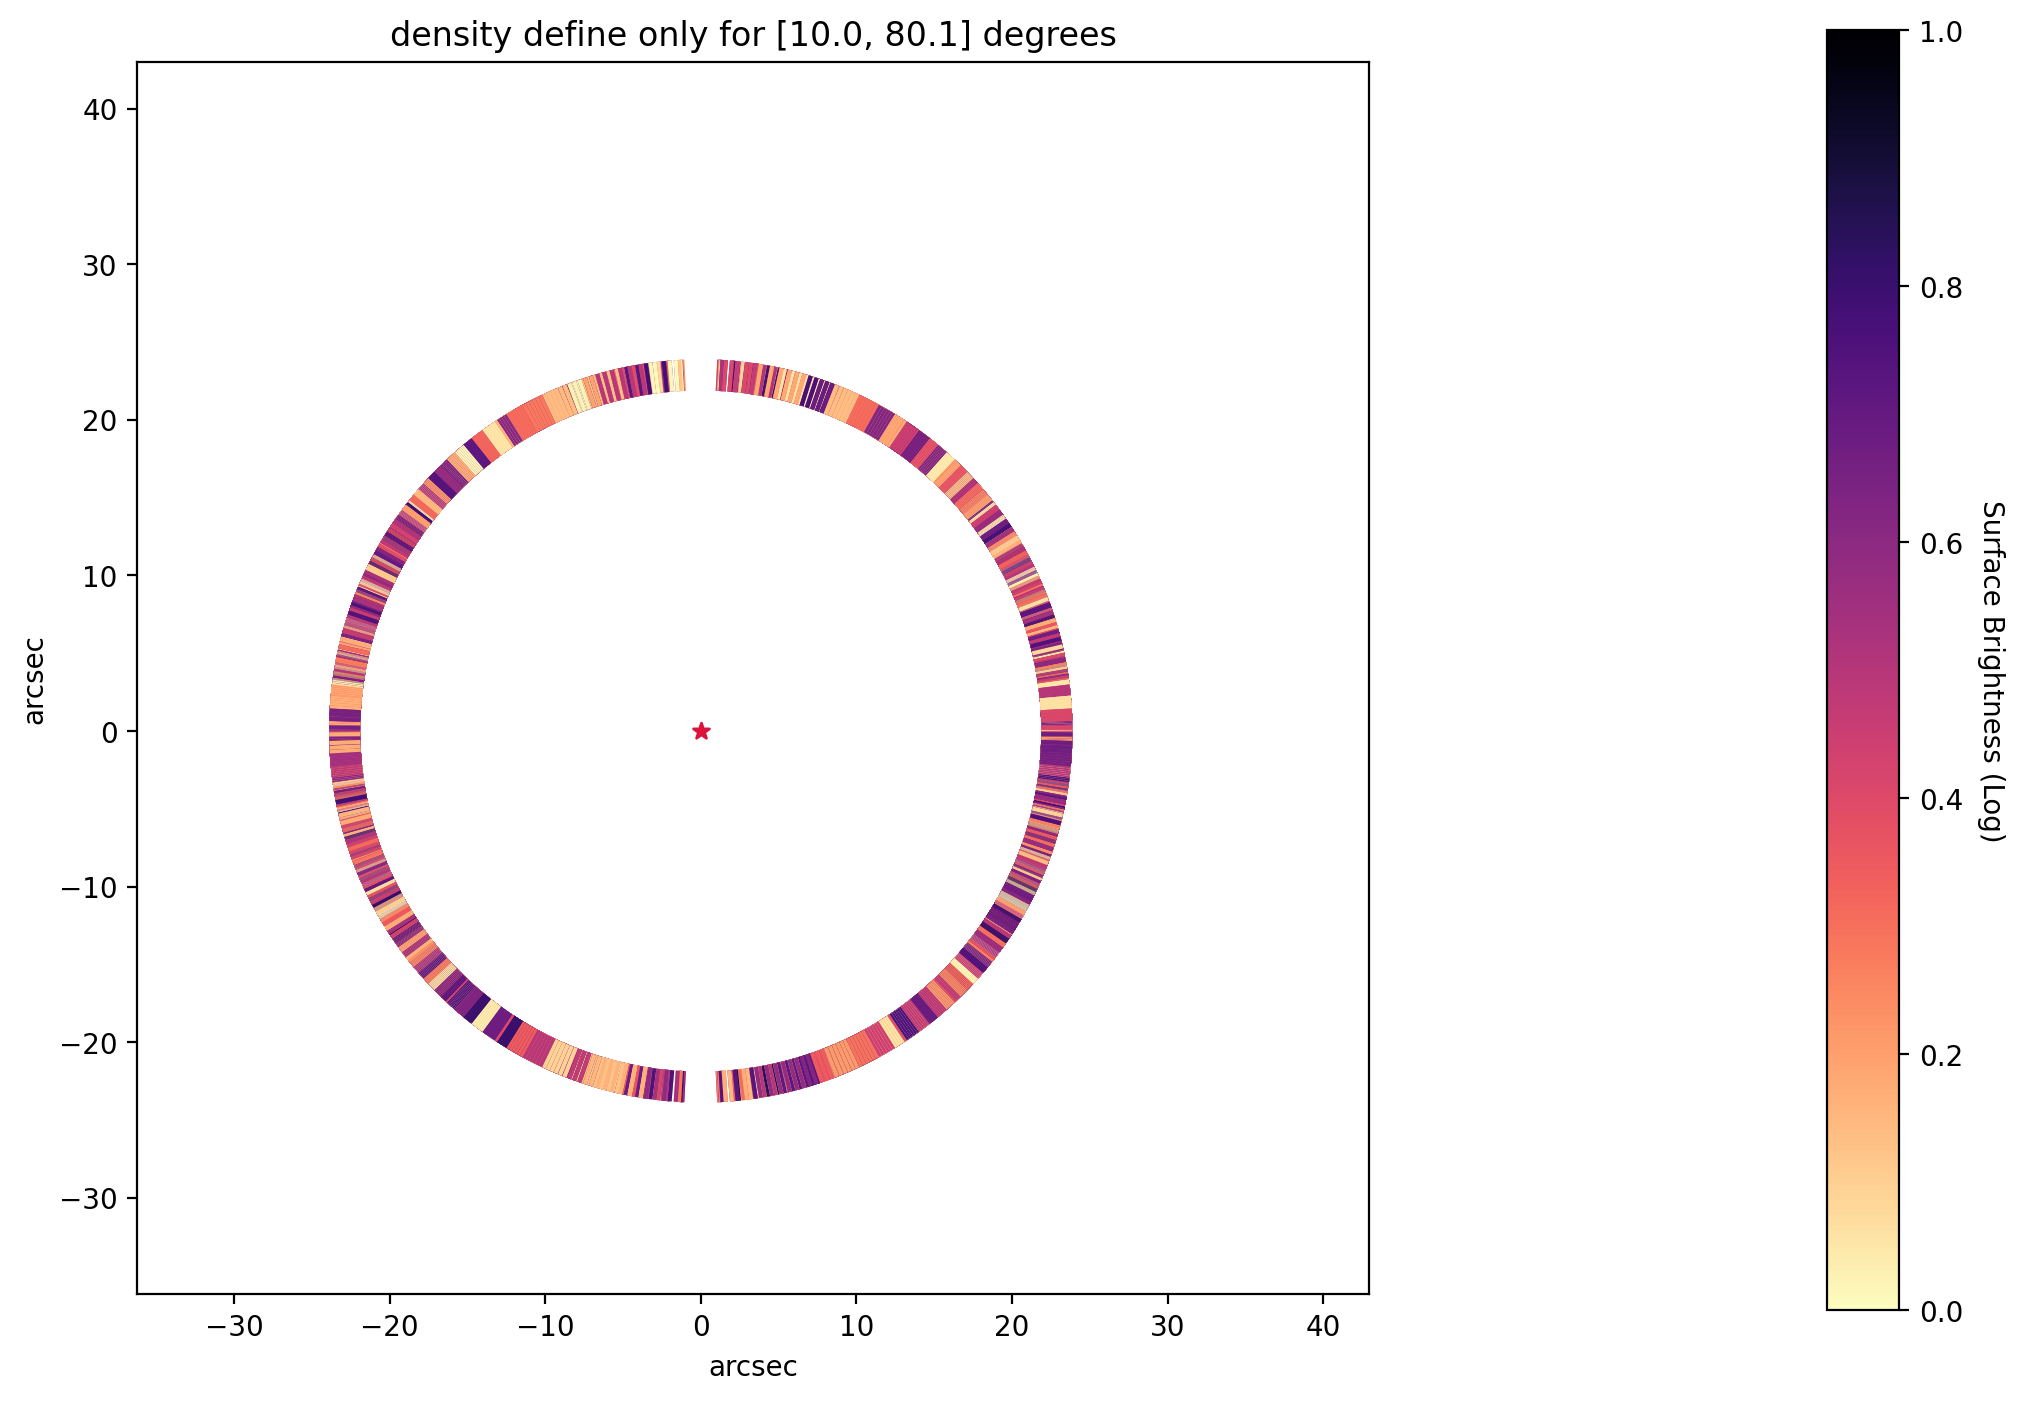

In [21]:
deltass = np.linspace(10, 80.1, 400)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[2], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )
<ipython-input-10-1114441001c9>:27: RuntimeWarning: invalid va

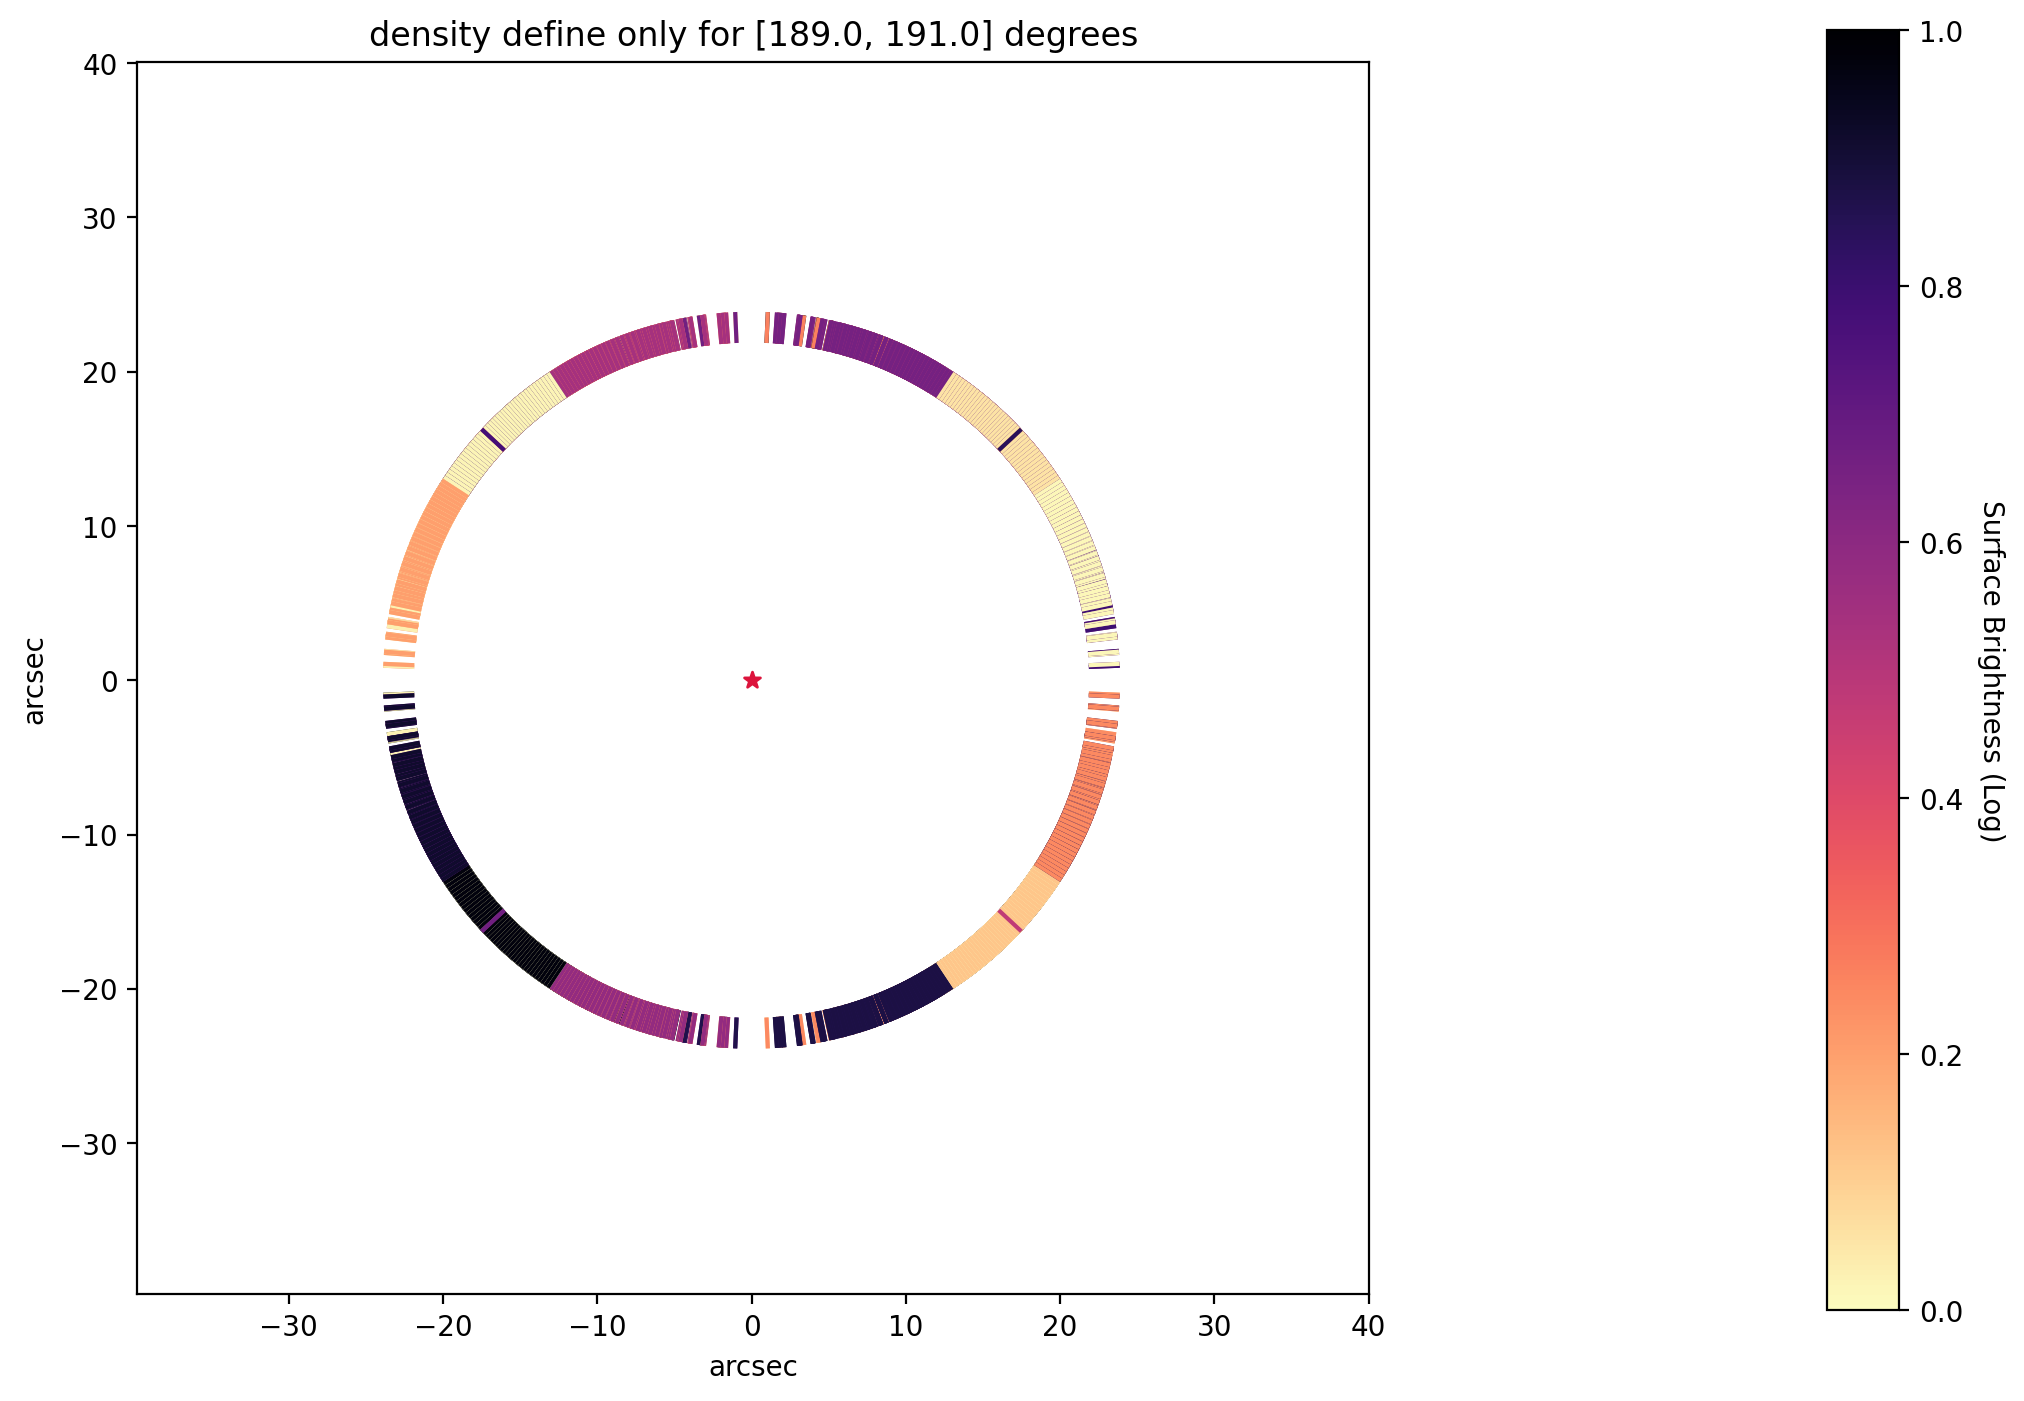

In [22]:
deltass = np.linspace(189, 191, 400)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[2], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )


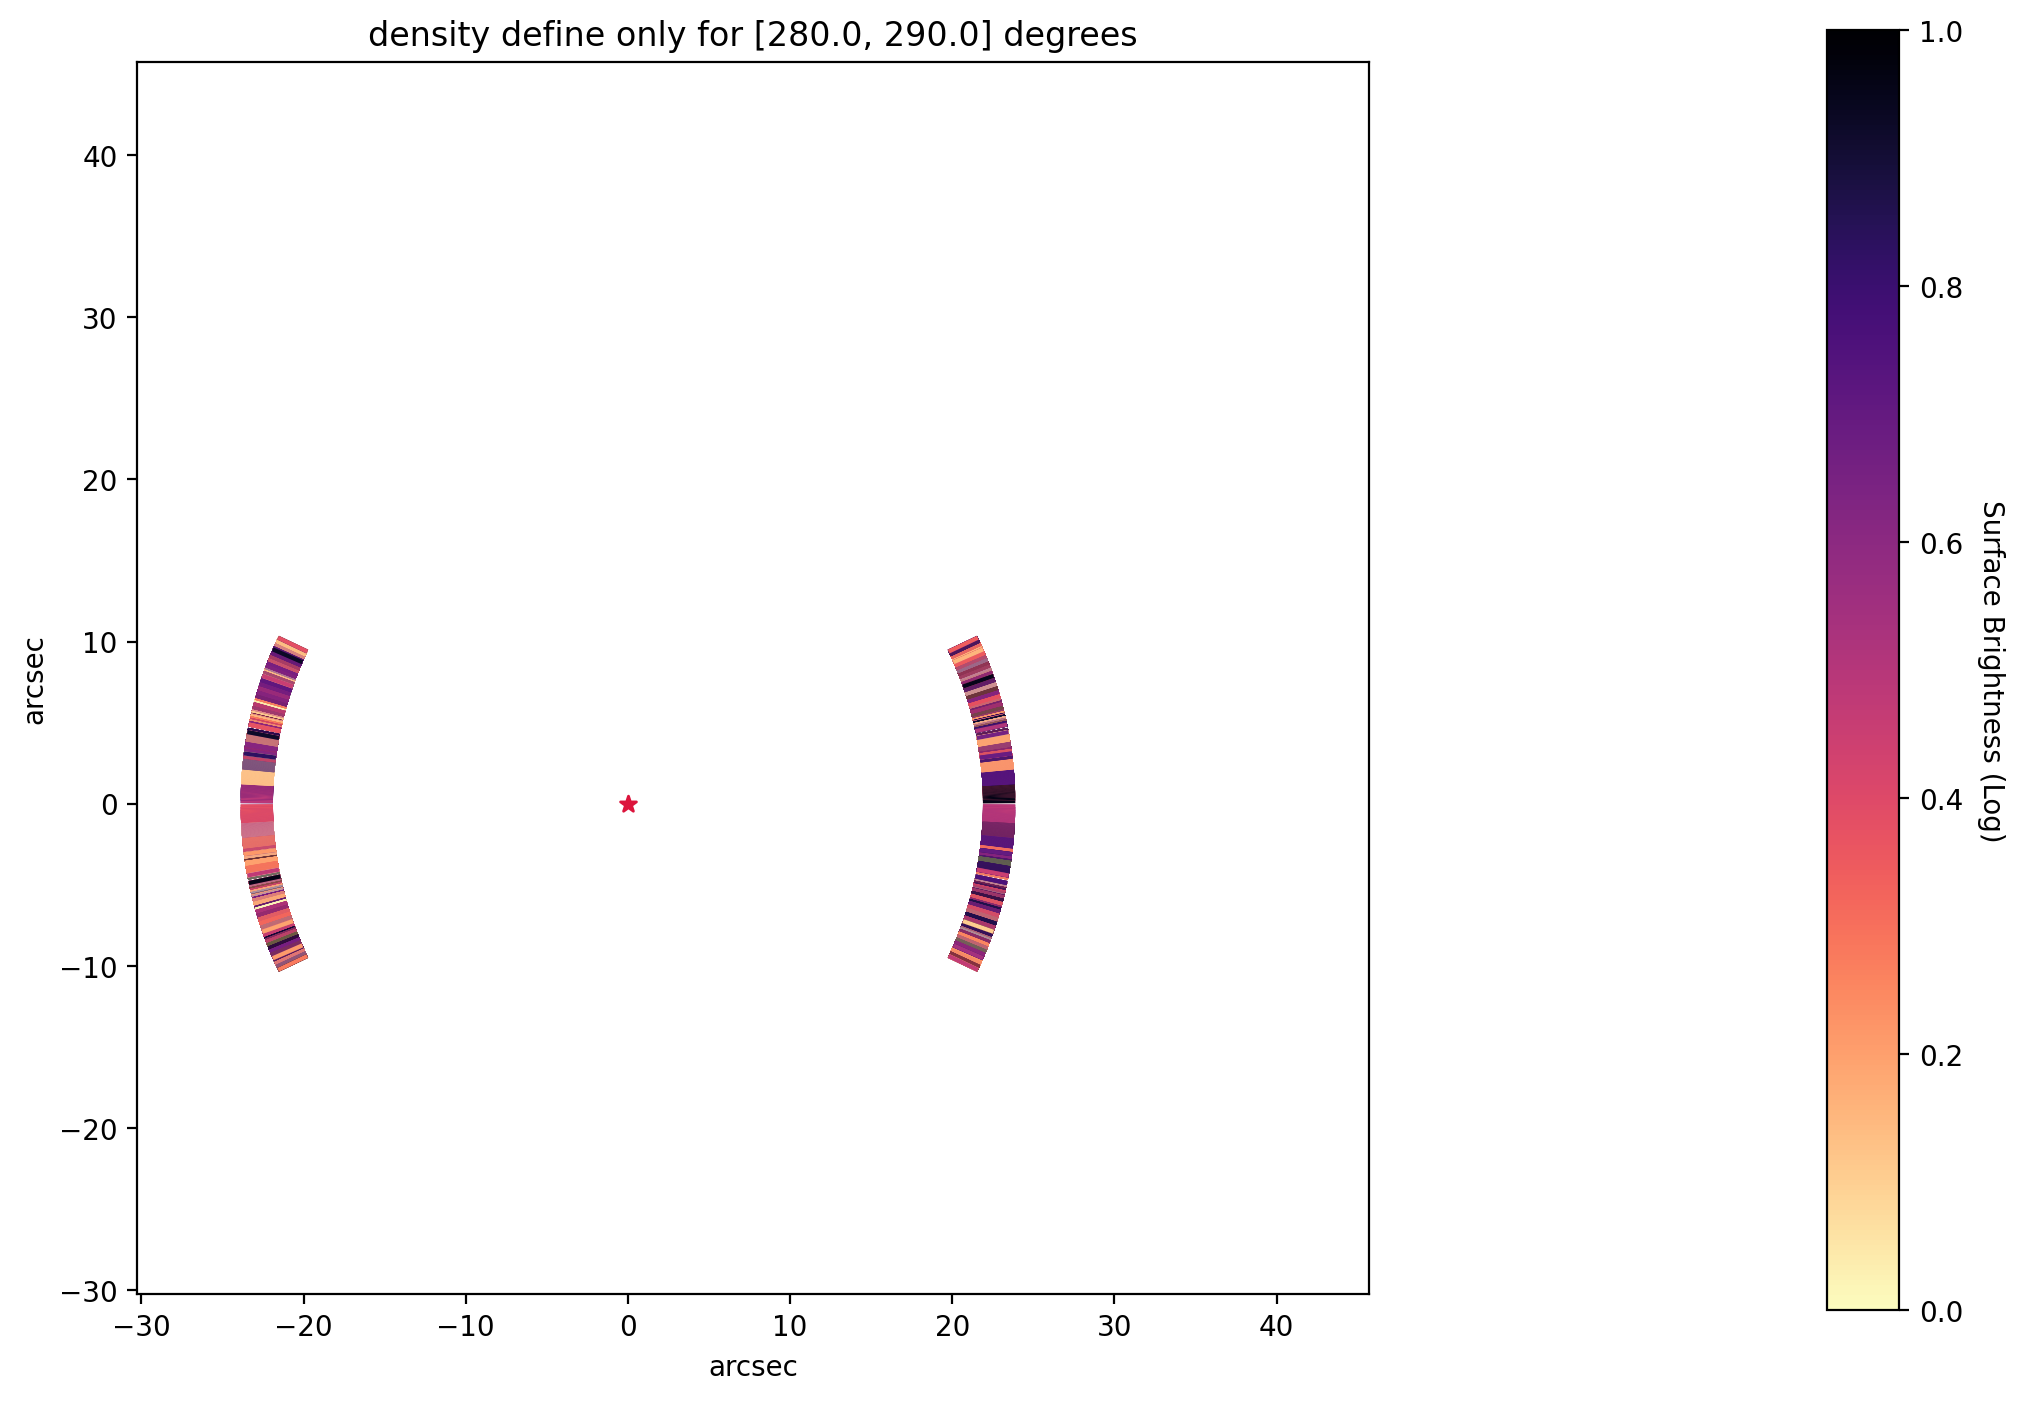

In [23]:
deltass = np.linspace(280, 290, 400)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[2], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

In [24]:
r0ly[0]

0.326156

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )
<ipython-input-10-1114441001c9>:27: RuntimeWarning: invalid va

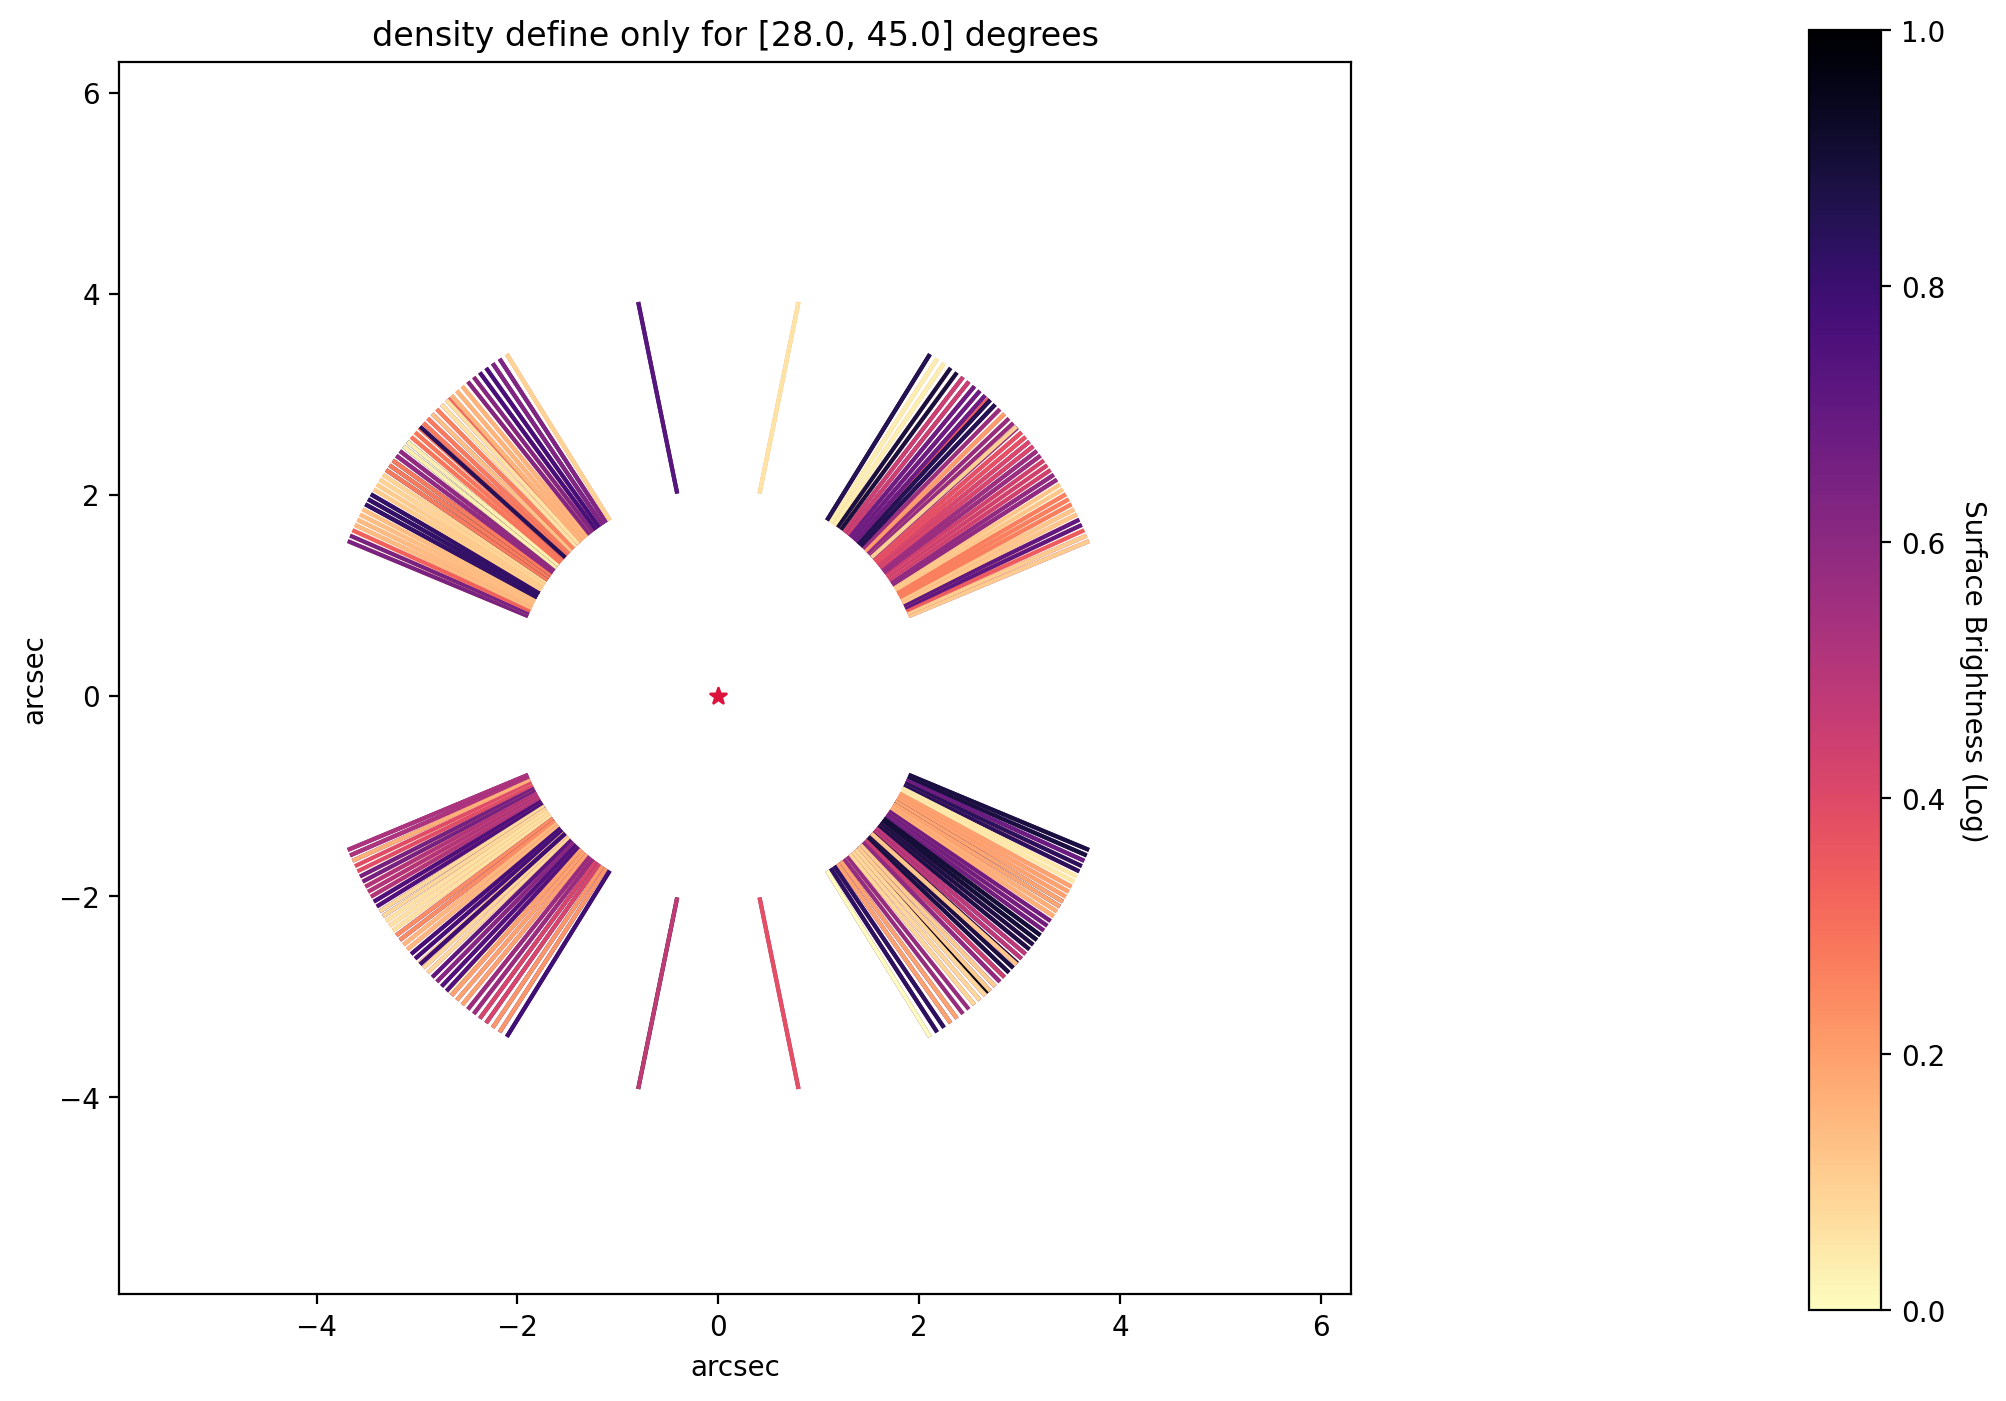

In [25]:
deltass = np.linspace(28, 45, 40)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[0], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

In [26]:
# new_xs

<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )
<ipython-input-10-1114441001c9>:27: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2)
<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(

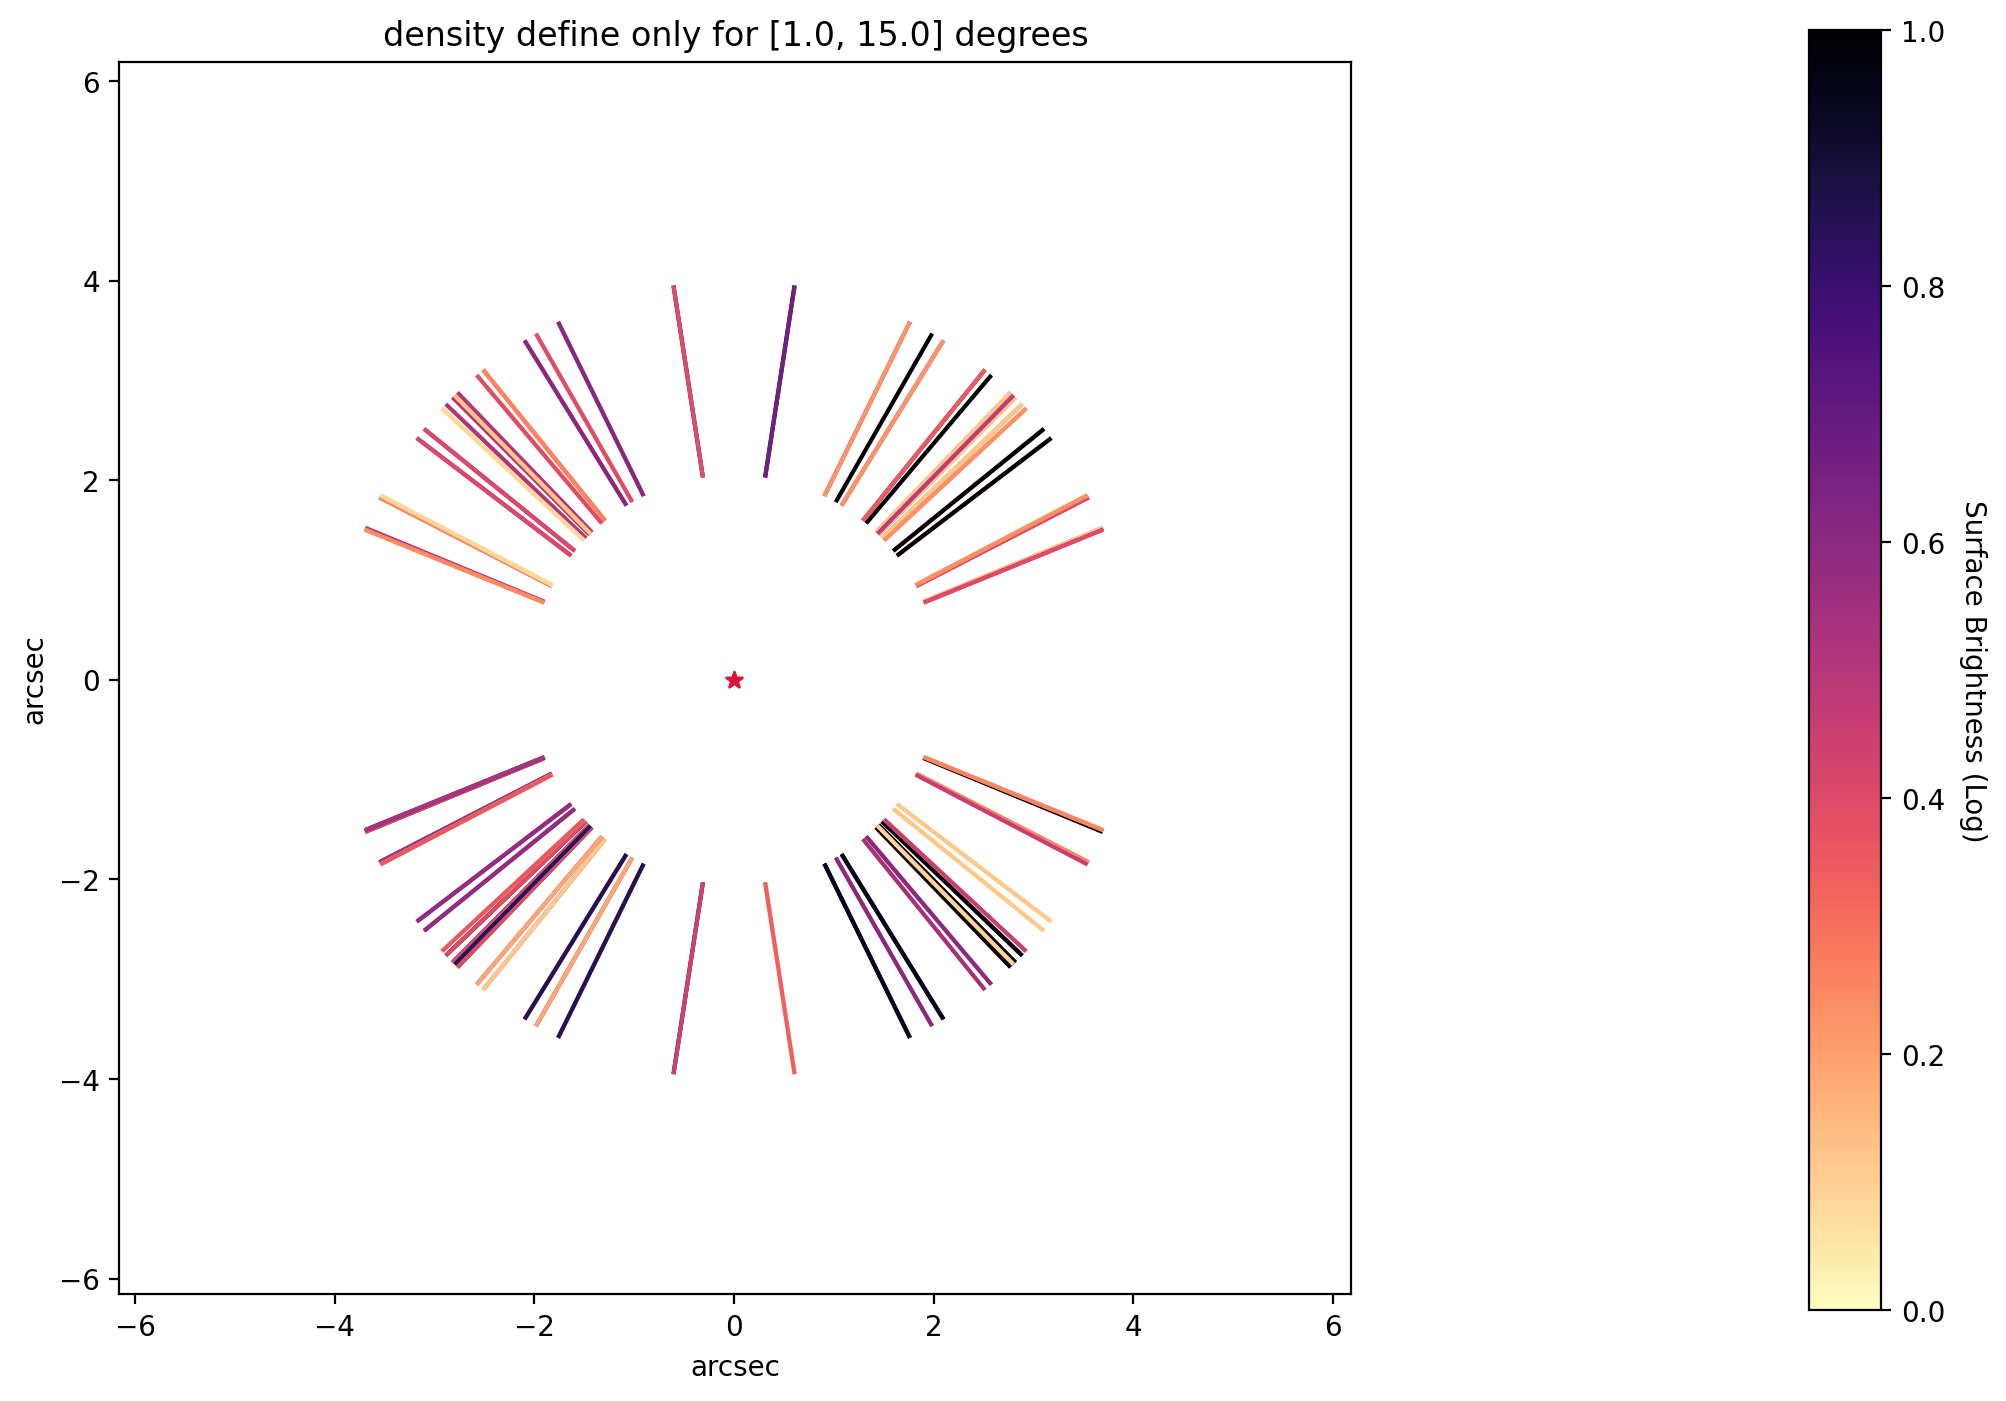

In [27]:
deltass = np.linspace(1, 15, 1000)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[0], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )
<ipython-input-10-1114441001c9>:27: RuntimeWarning: invalid va

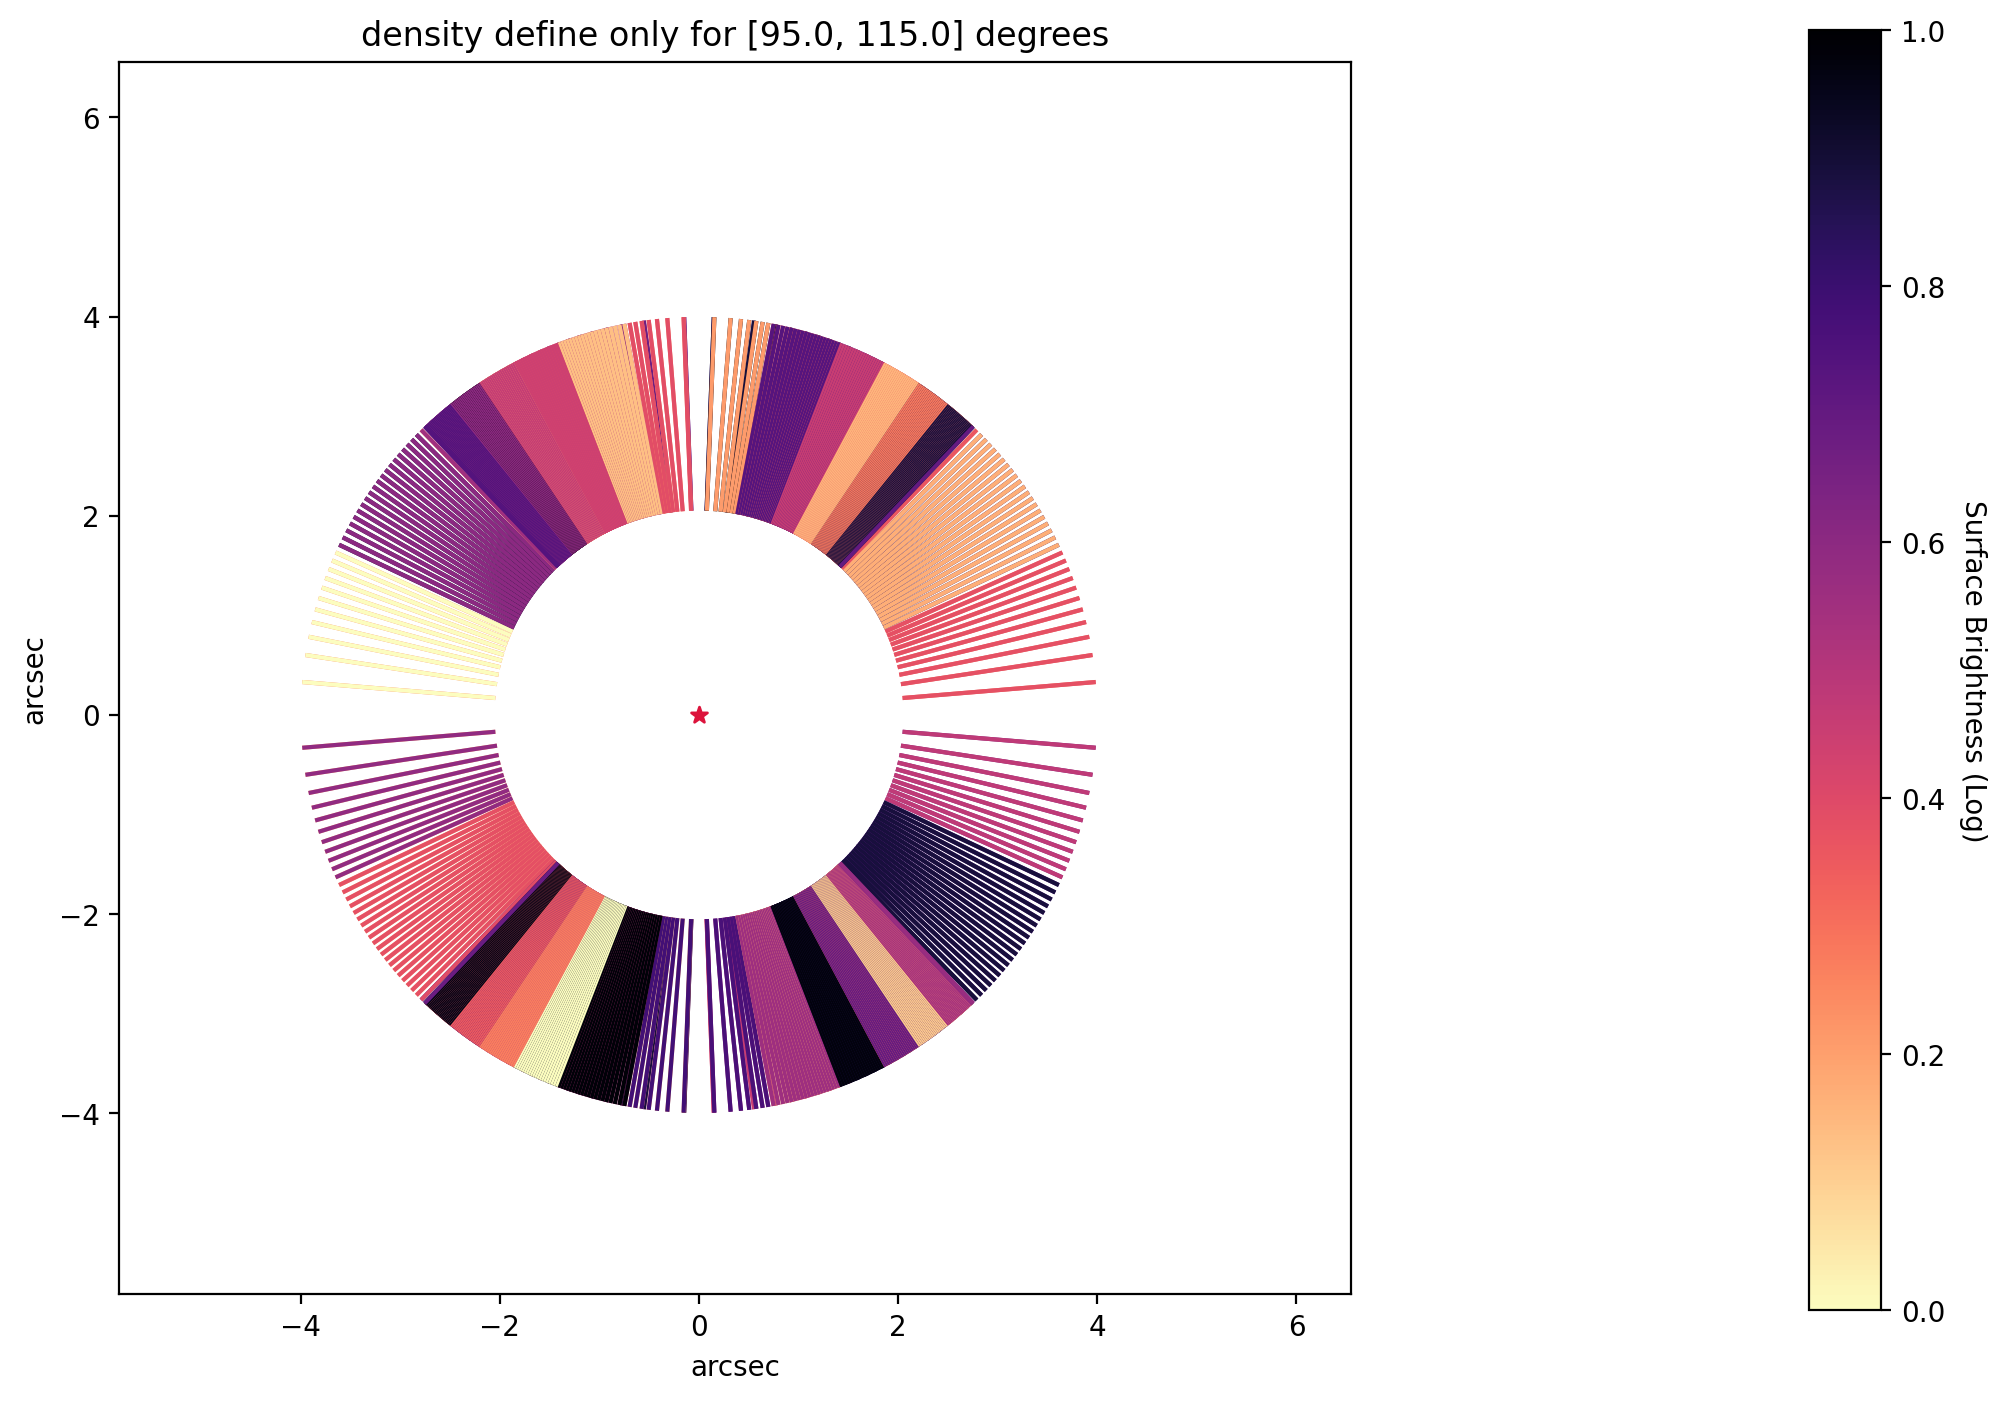

In [28]:
deltass = np.linspace(95, 115, 400)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[0], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:27: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2)
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(

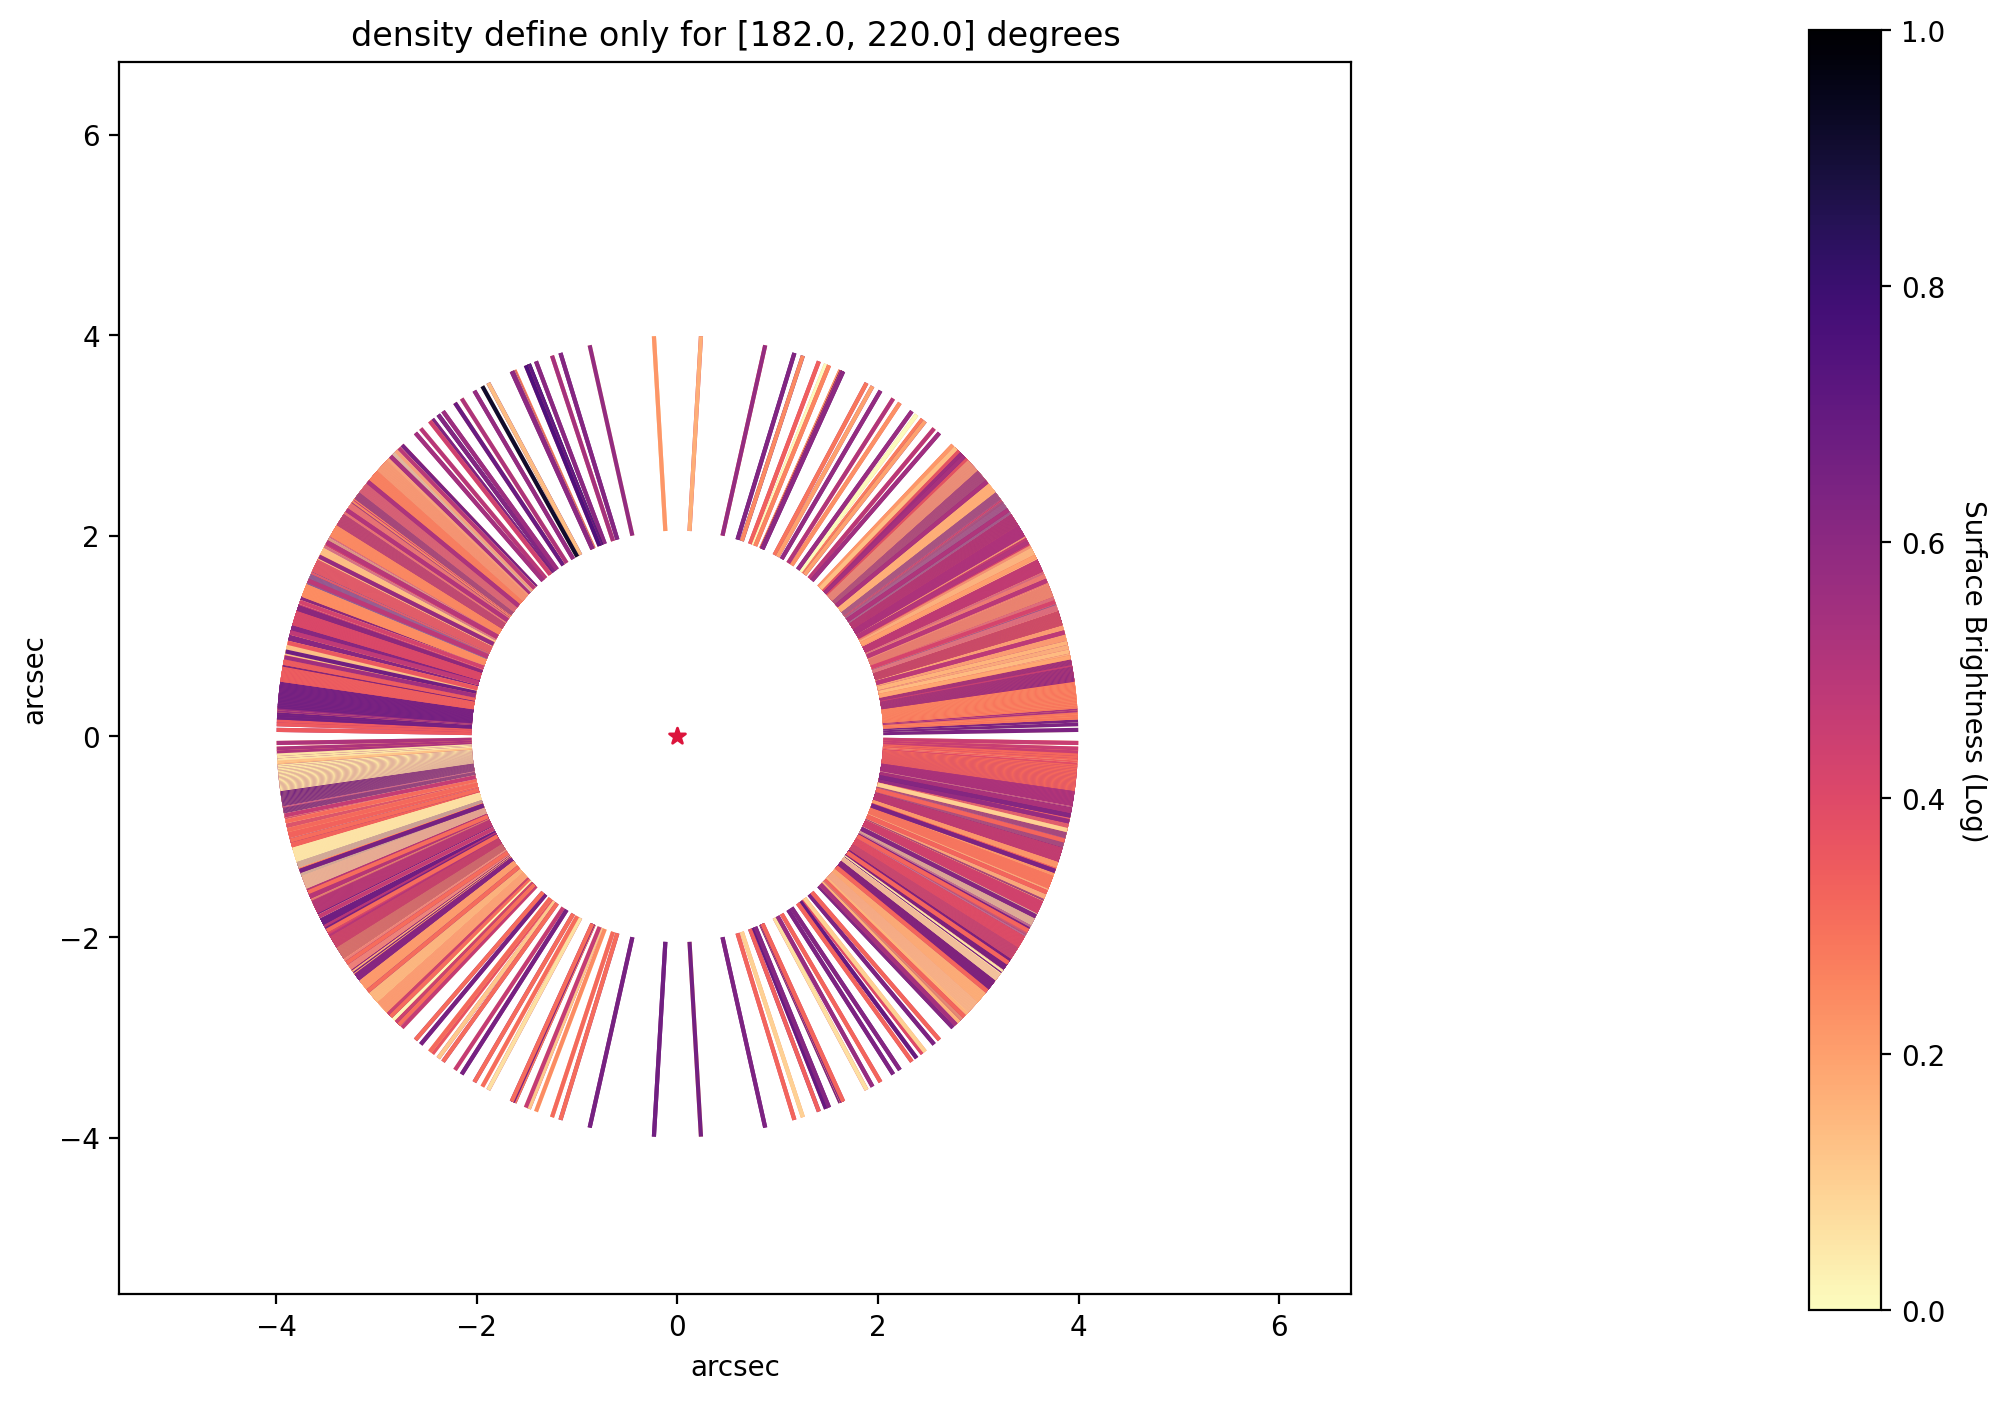

In [29]:
deltass = np.linspace(182, 220, 1000)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[0], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )
<ipython-input-10-1114441001c9>:27: RuntimeWarning: invalid va

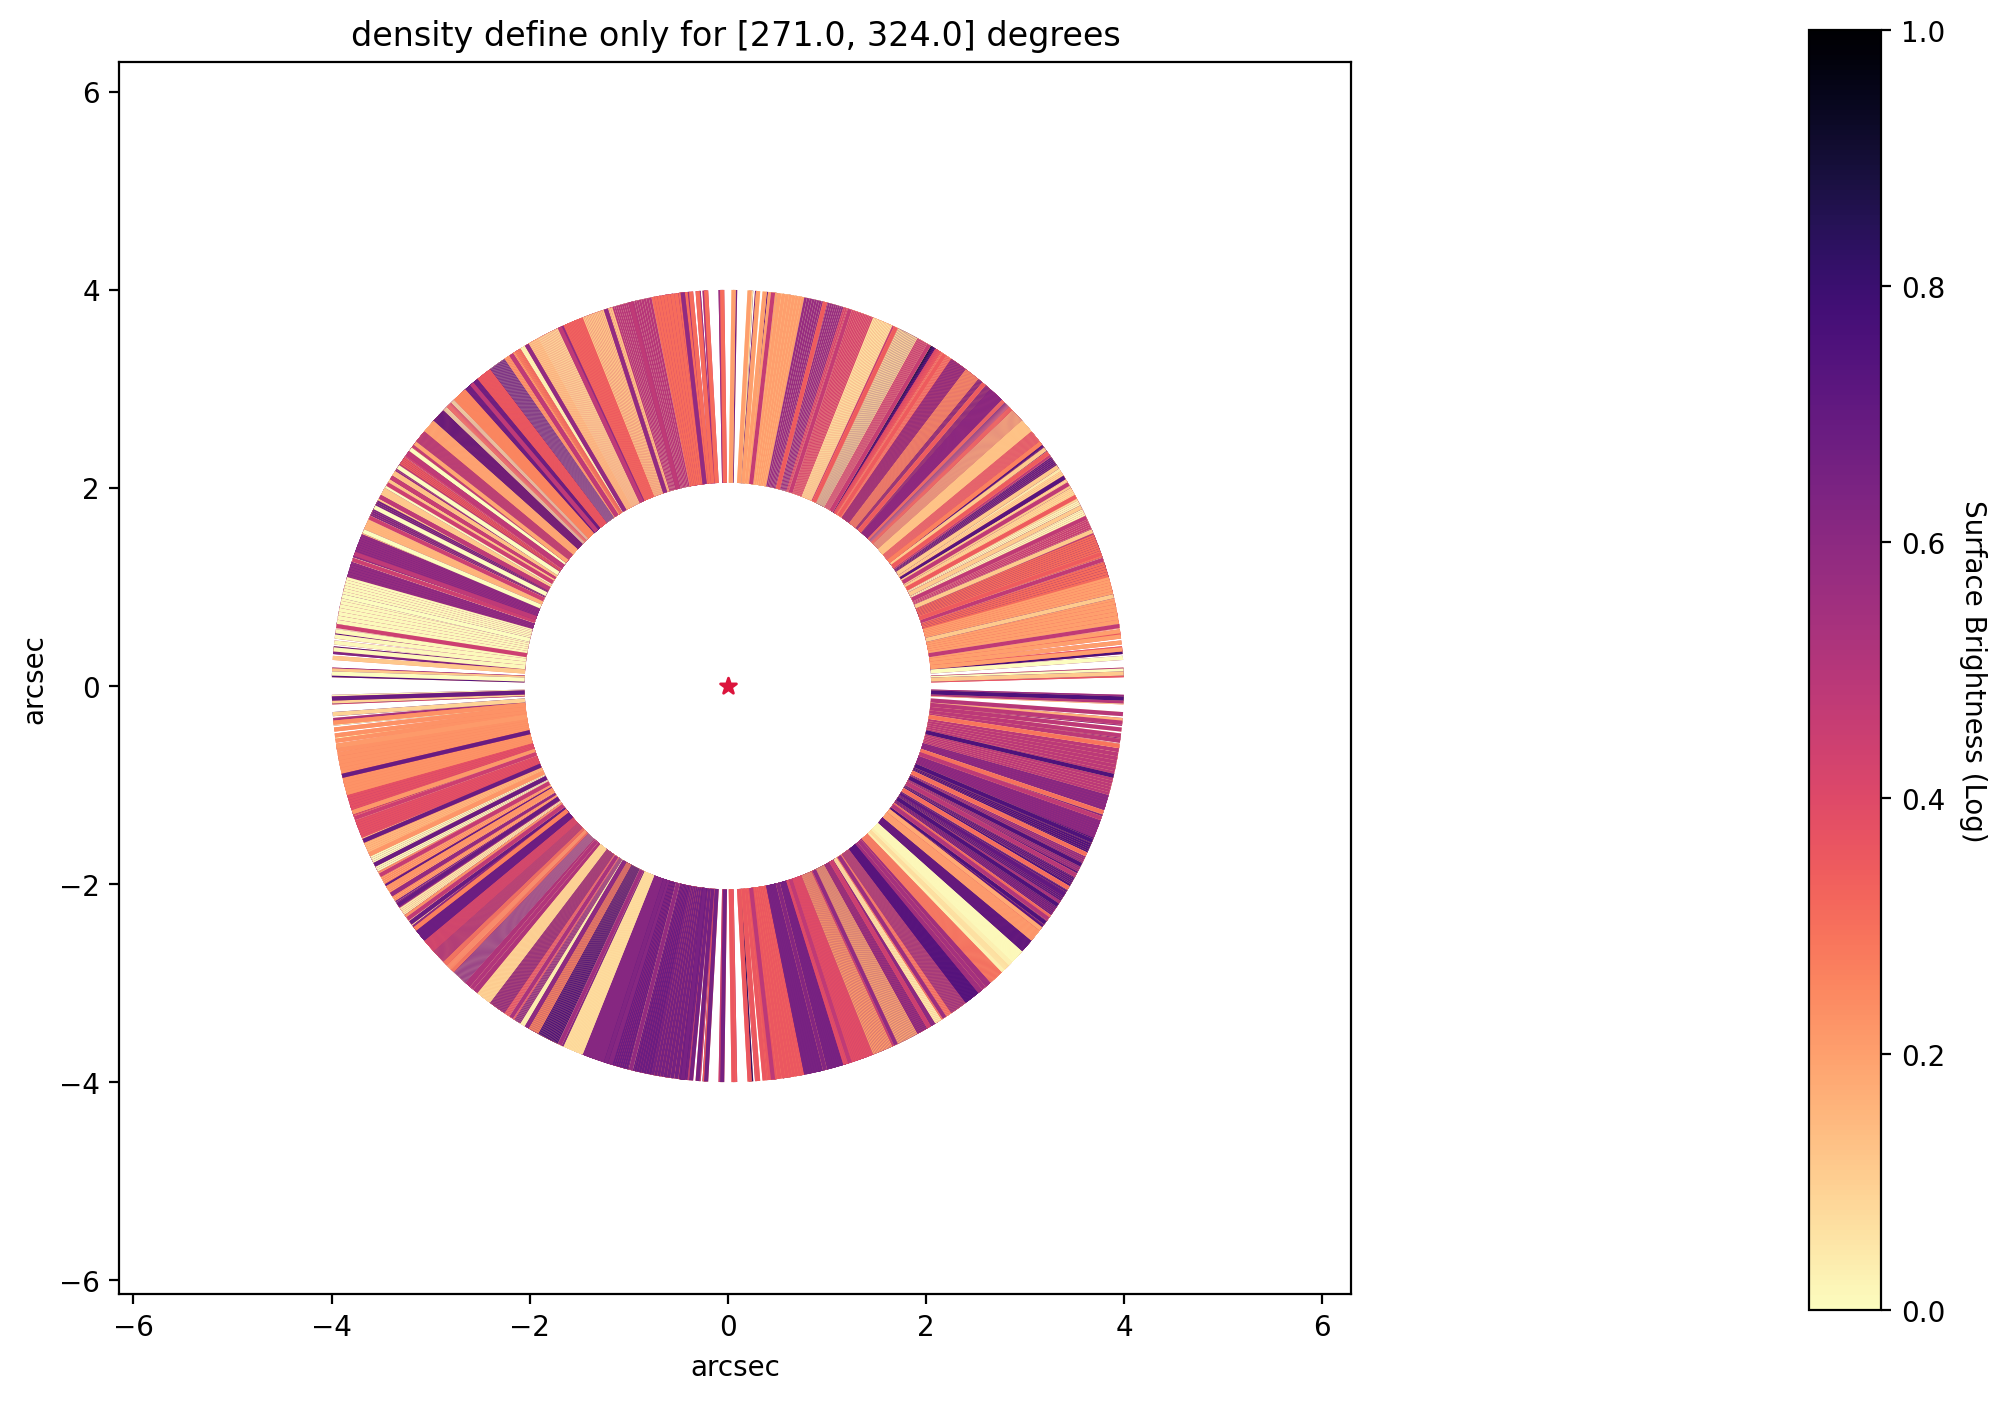

In [30]:
deltass = np.linspace(271, 324, 1000)
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[0], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid value encountered in sqrt
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:21: RuntimeWarning: invalid value encountered in sqrt
  y_inv4 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) - ct**2 + (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (-(np.cos(np.deg2rad(delta))+ 1)) )
<ipython-input-10-1114441001c9>:27: RuntimeWarning: invalid va

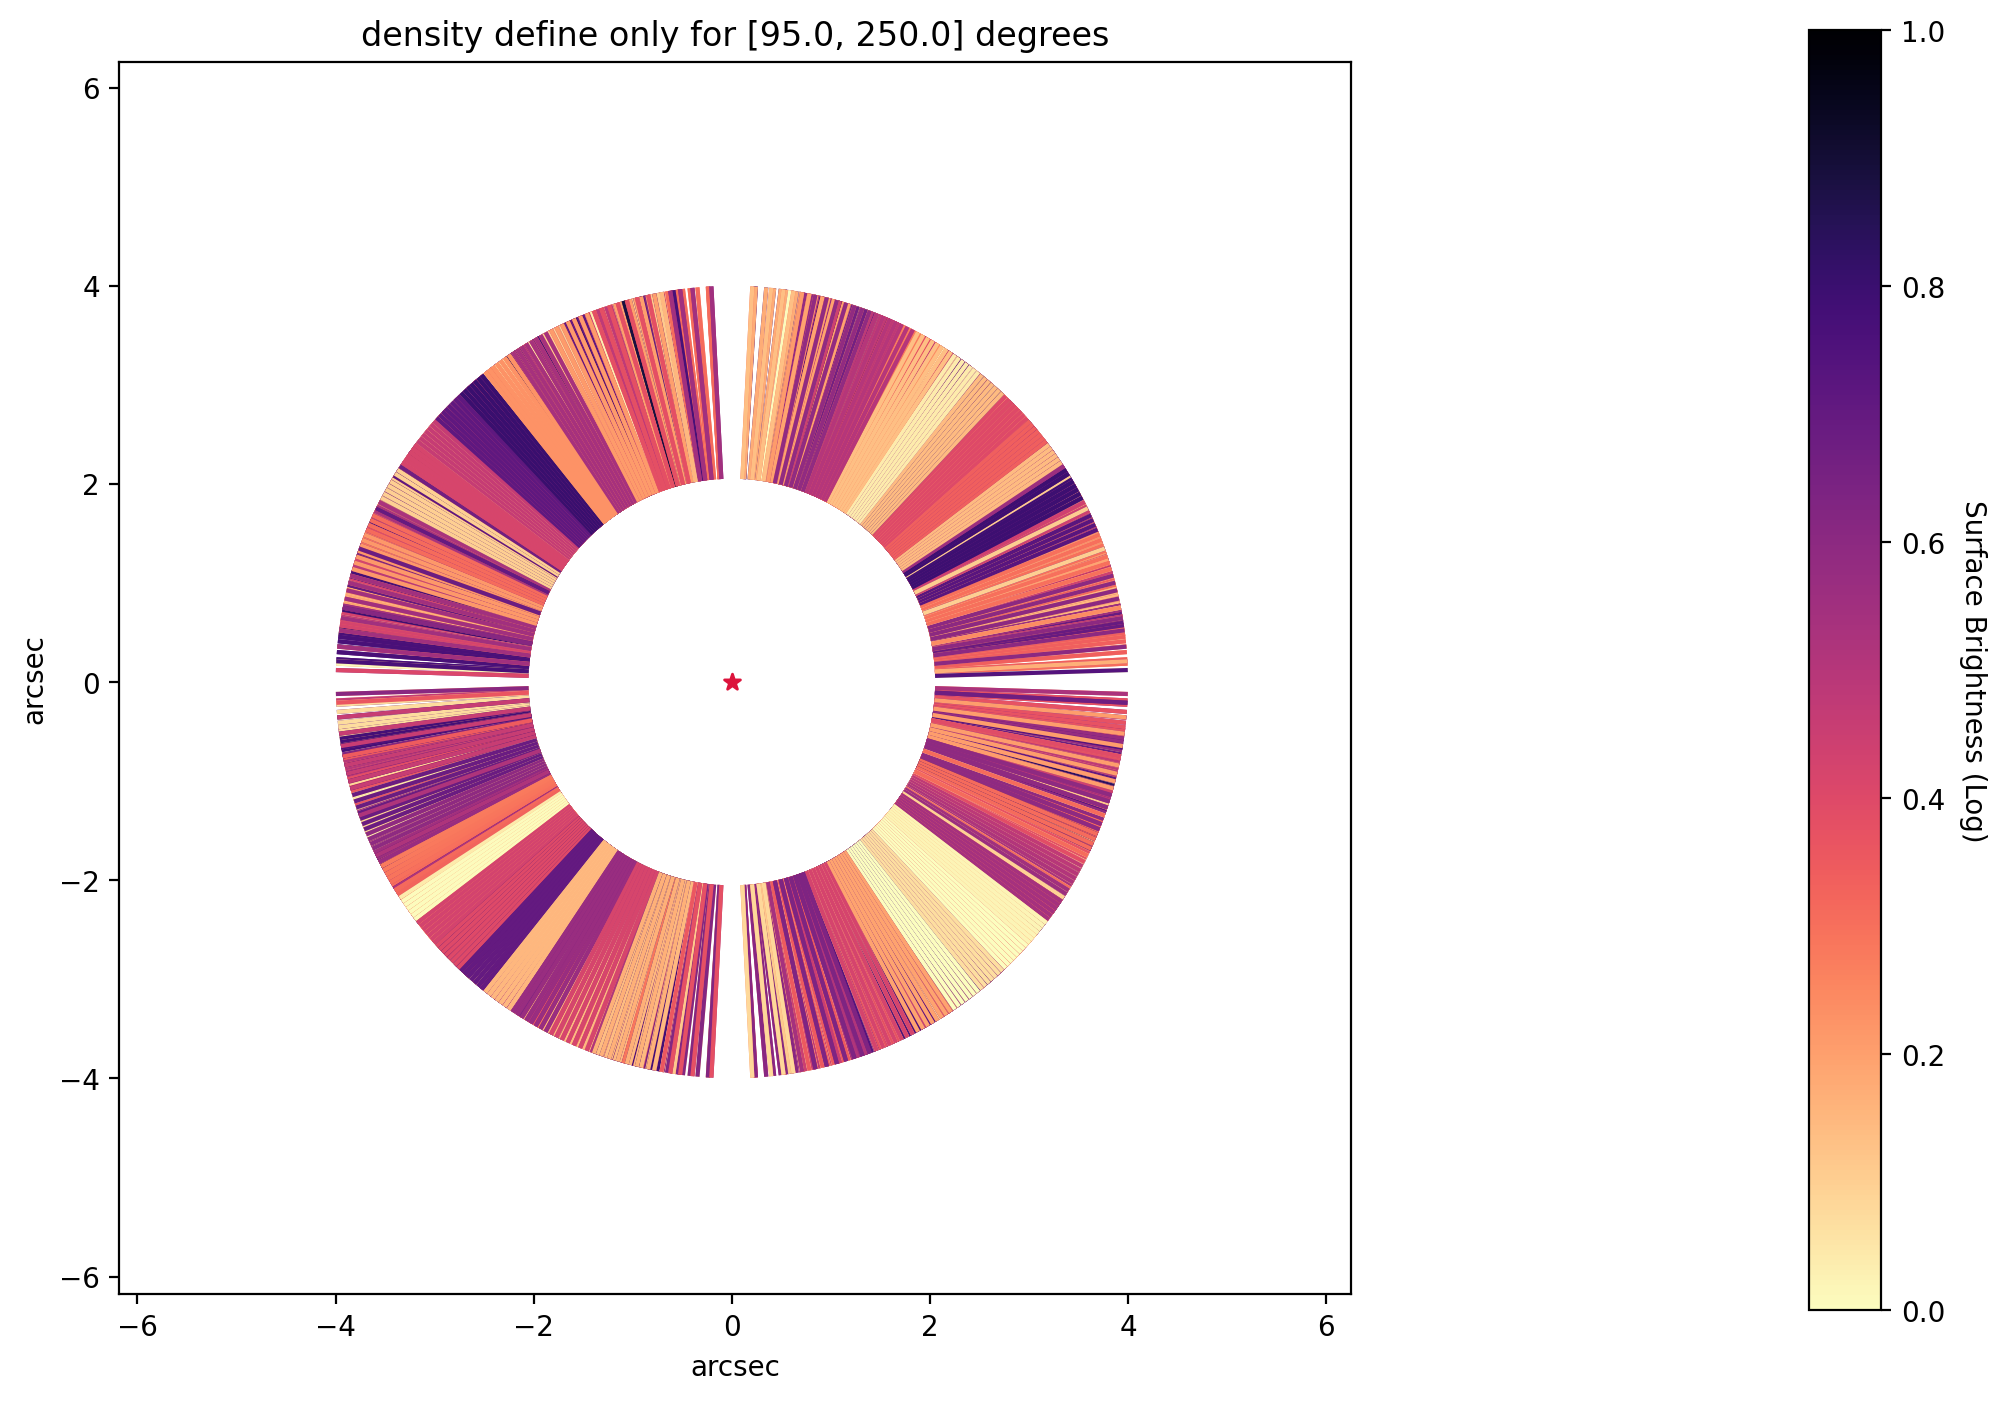

In [31]:
deltass1 = np.linspace(95, 115, 500)
deltass2 = np.linspace(182, 250, 500)
deltass = np.concatenate((deltass1, deltass2))
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[0], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

In [32]:
surface.shape

(4440,)

In [33]:
surface.max(), surface.min()

(1.8291099955493485e+17, 6235186280625.439)

(array([400., 585., 596., 564., 640., 525., 460., 614.,  55.,   1.]),
 array([6.23518628e+12, 1.82967116e+16, 3.65871881e+16, 5.48776645e+16,
        7.31681409e+16, 9.14586174e+16, 1.09749094e+17, 1.28039570e+17,
        1.46330047e+17, 1.64620523e+17, 1.82911000e+17]),
 <BarContainer object of 10 artists>)

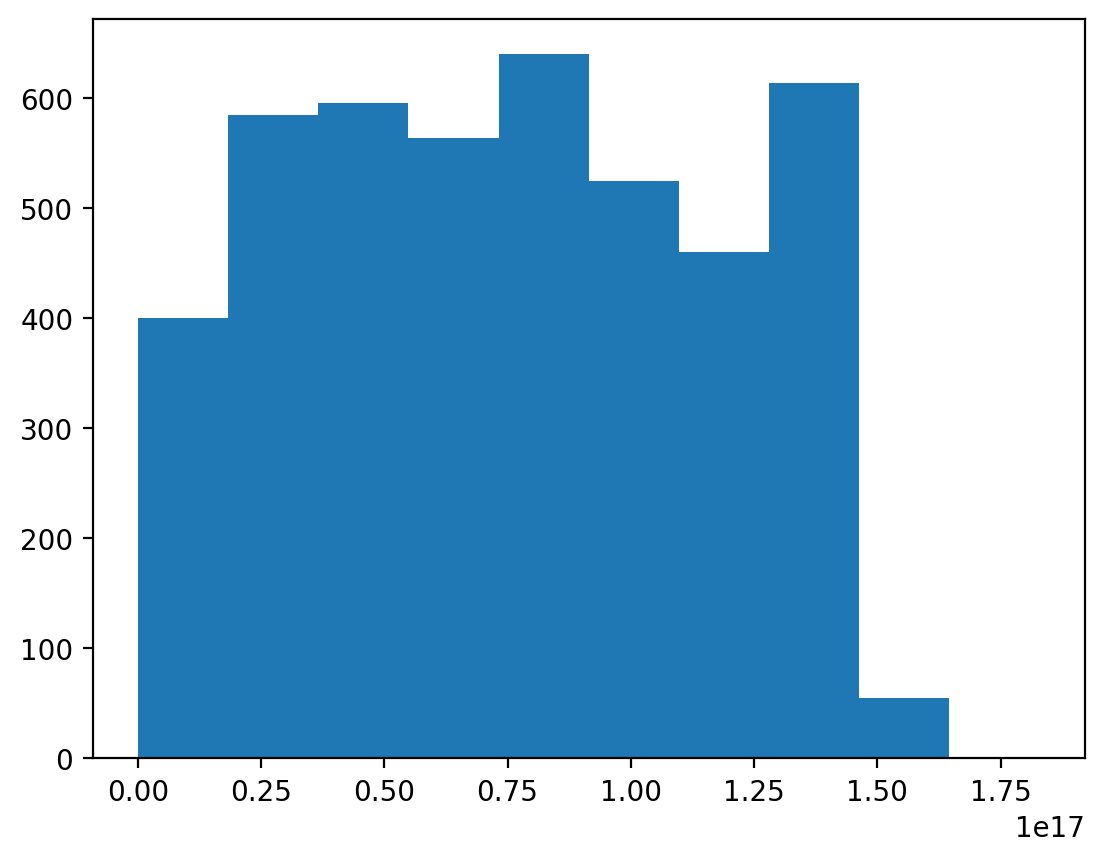

In [34]:
plt.hist(surface)

<ipython-input-10-1114441001c9>:18: RuntimeWarning: divide by zero encountered in divide
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: divide by zero encountered in divide
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid

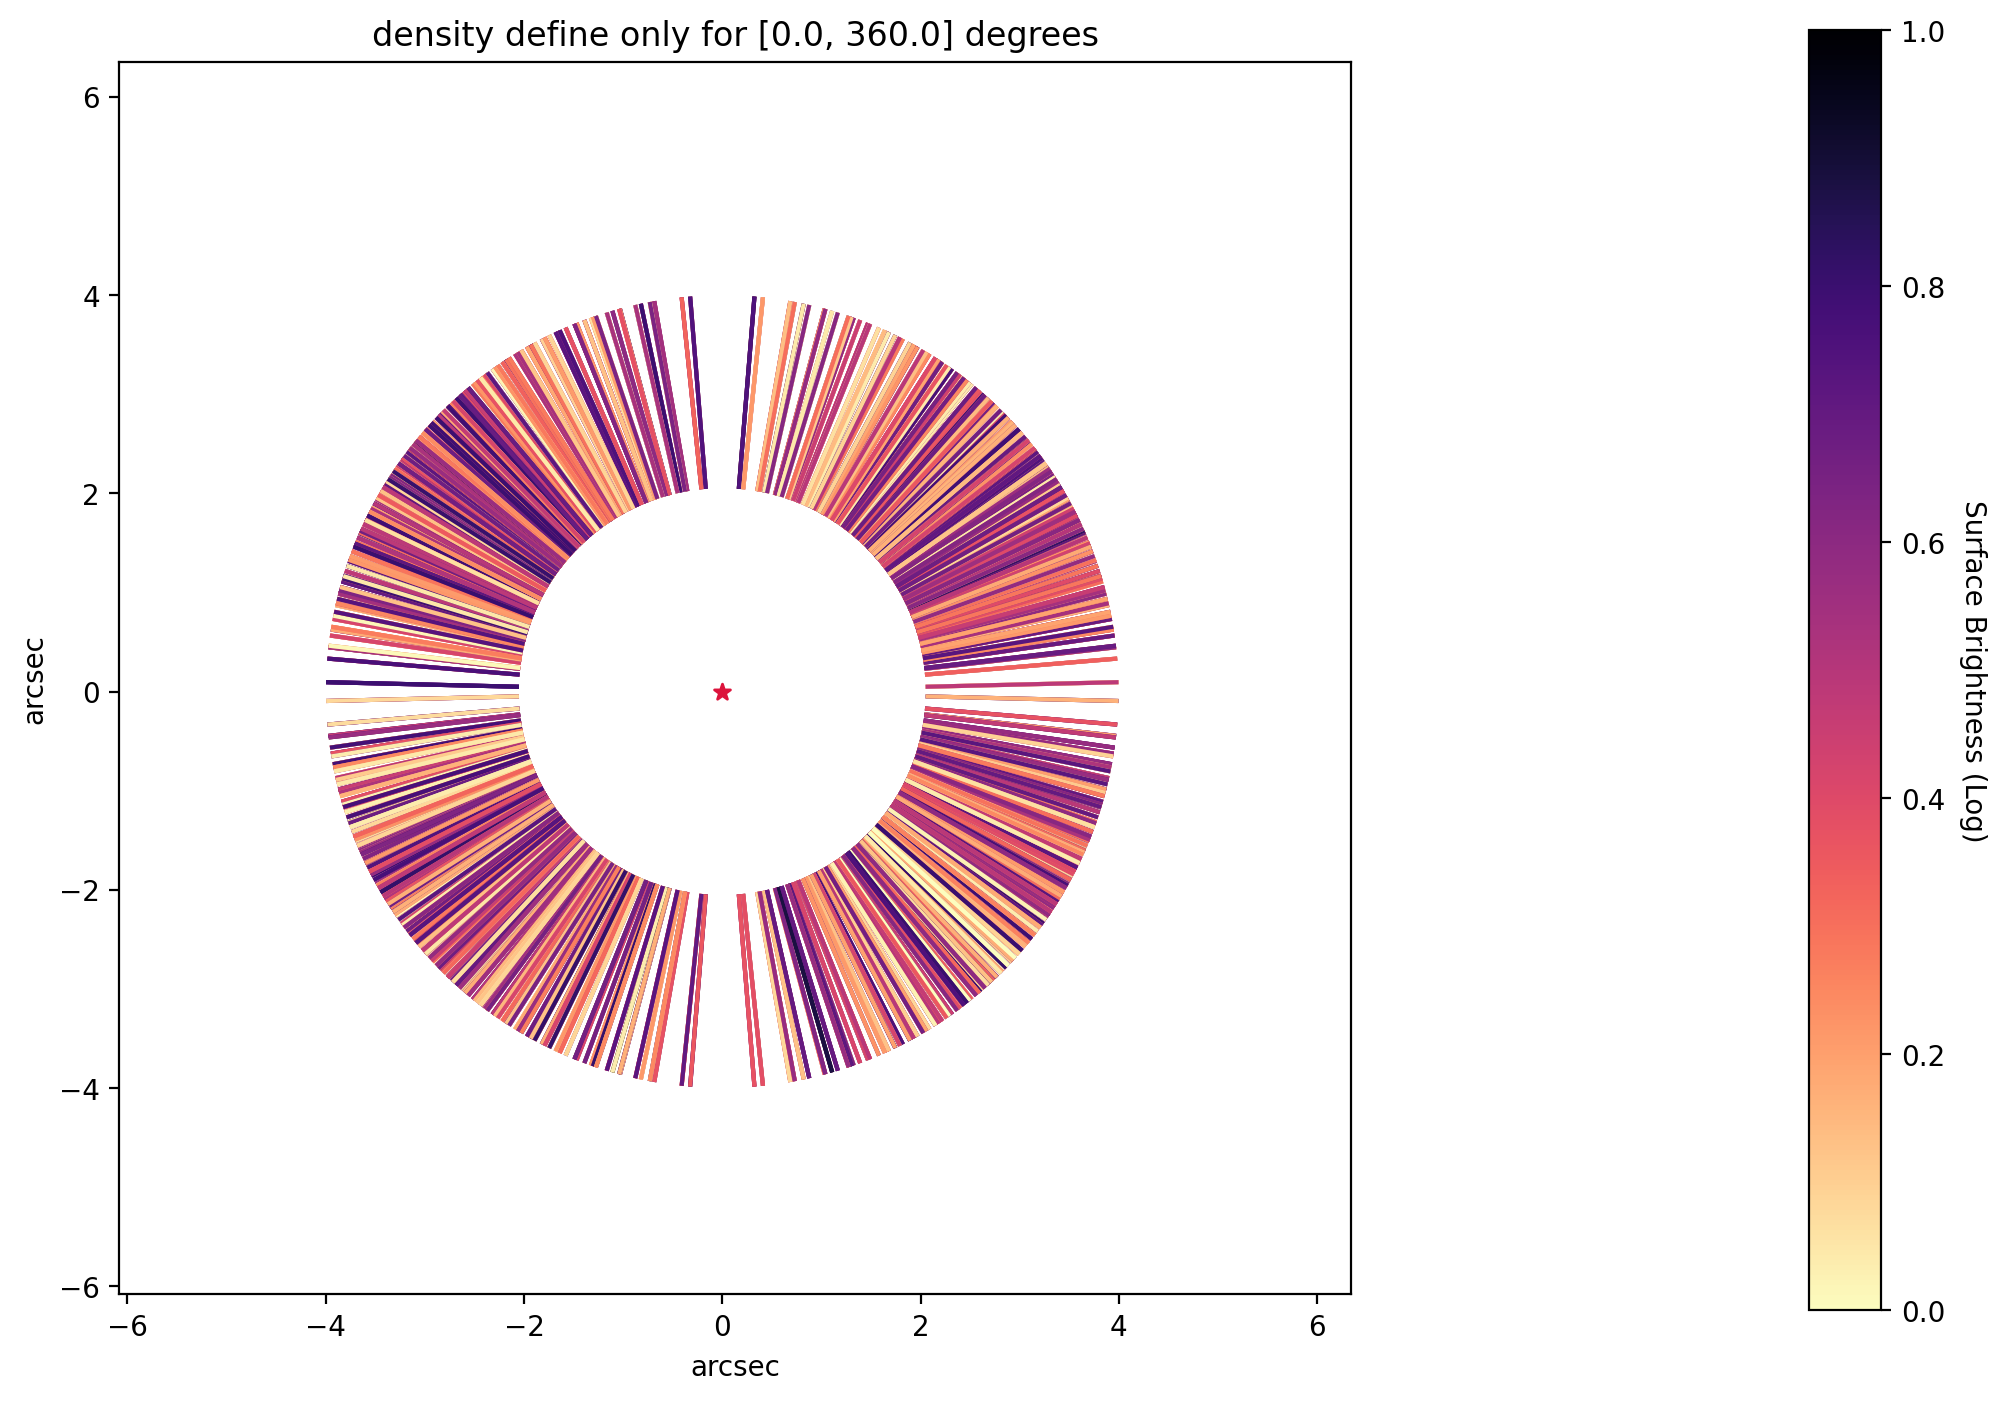

In [35]:
deltass = np.linspace(0, 360, 500)
# deltass2 = np.linspace(182, 250, 500)
# deltass = np.concatenate((deltass1, deltass2))
new_xs, new_ys, surface = LE_xy_surface_concate( r0ly[0], ct, deltass, x)
plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

<ipython-input-10-1114441001c9>:18: RuntimeWarning: divide by zero encountered in divide
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: divide by zero encountered in divide
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid

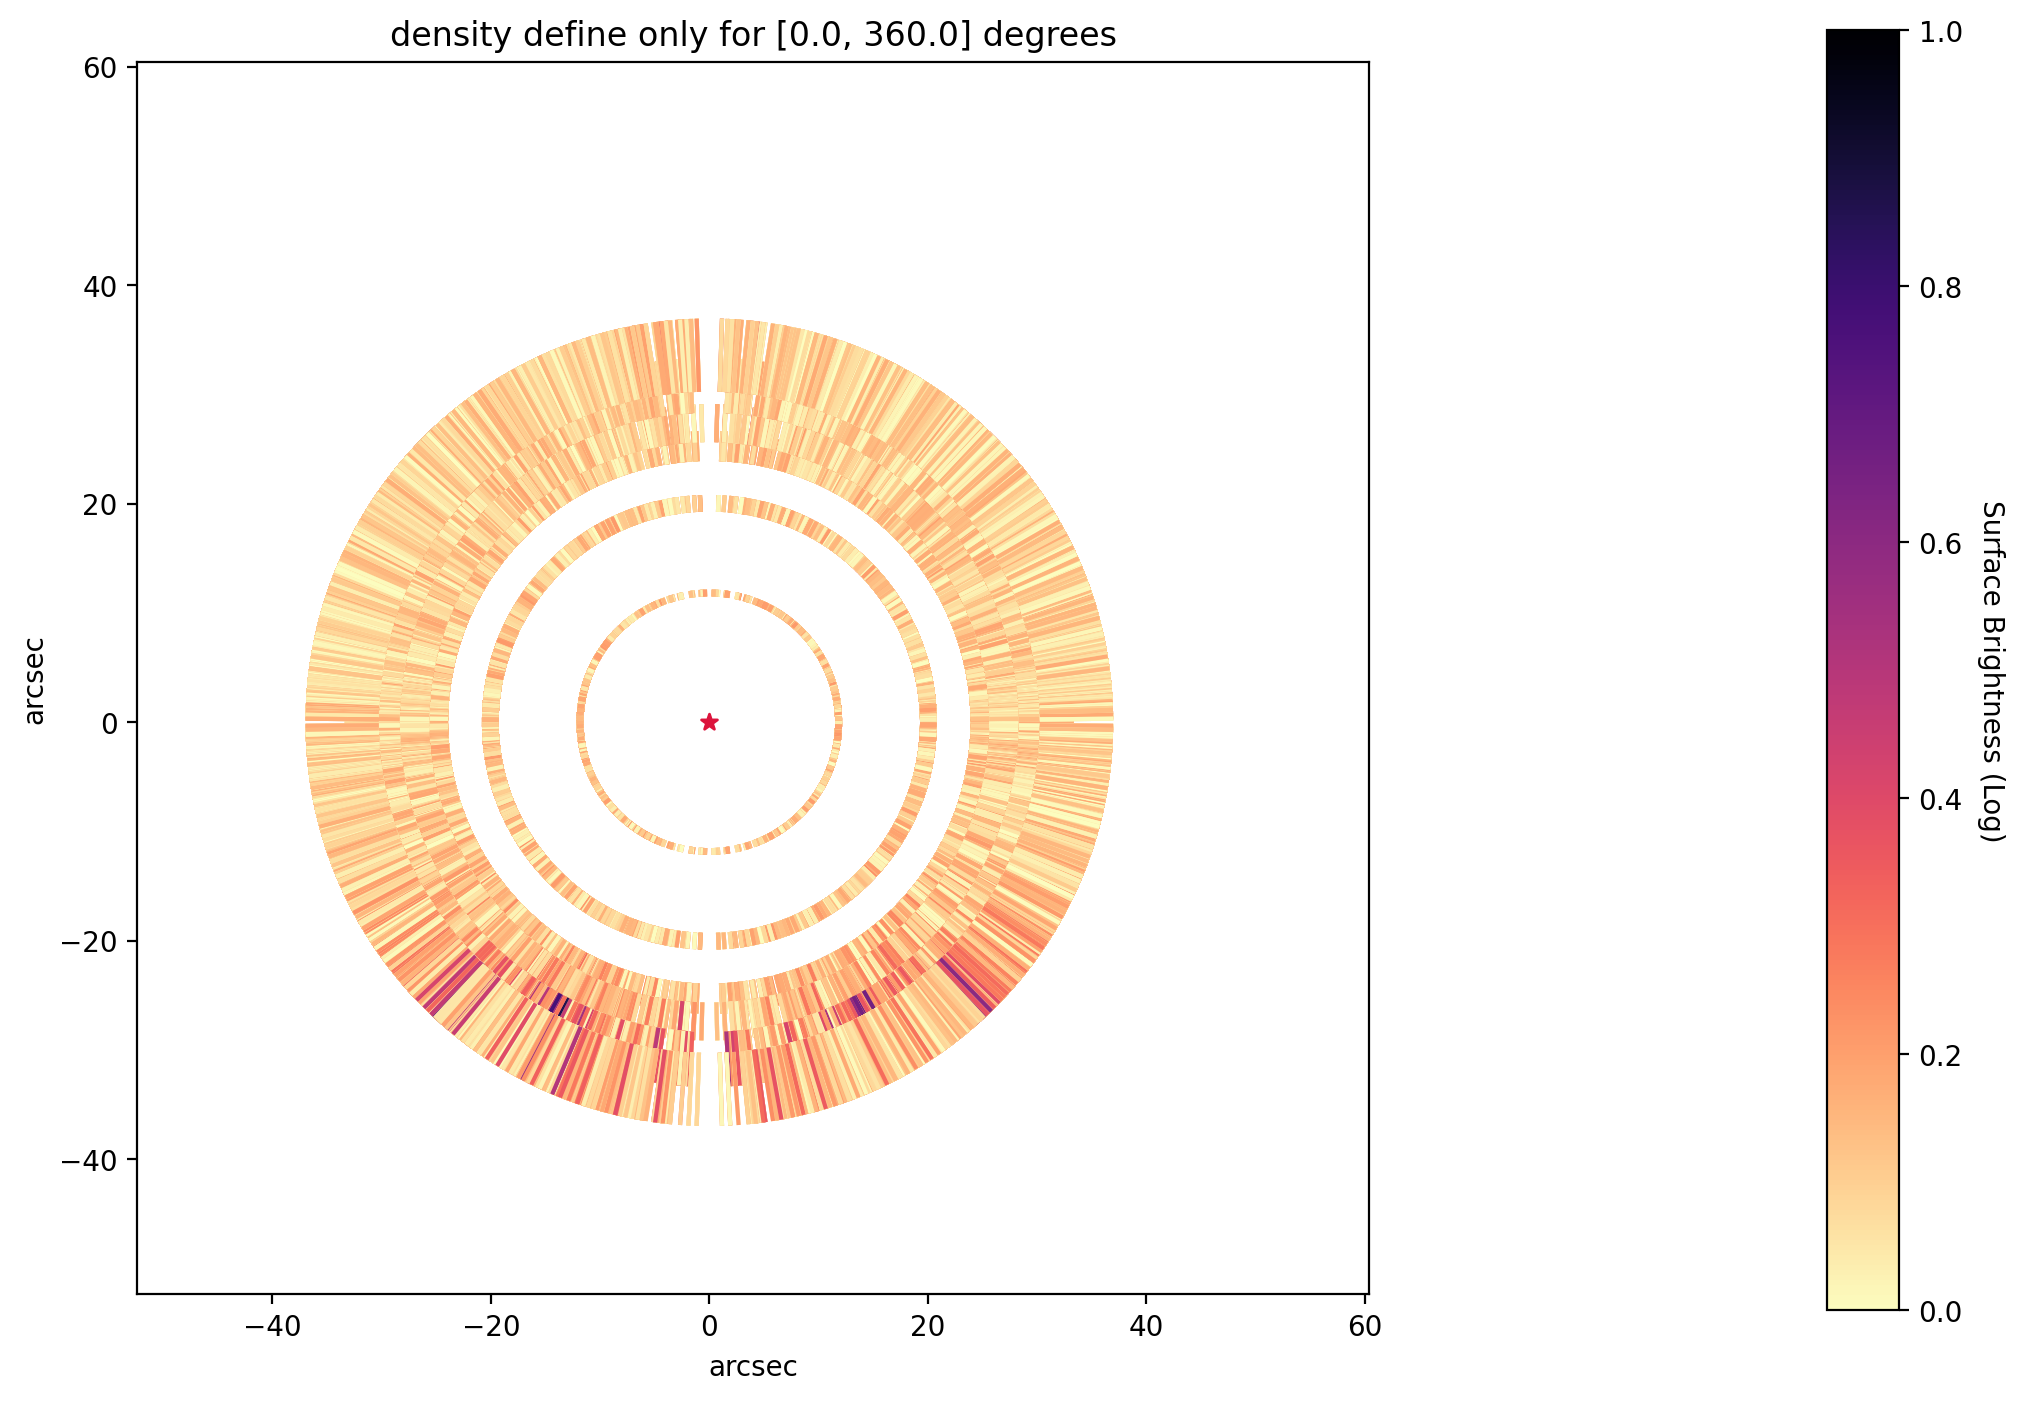

In [36]:
Deltat = [50, 150, 250, 300, 400, 500] # days
Deltat_y = np.array(Deltat) * dtoy


new_xs_list = []
new_ys_list = []
surface_list = []

for ct in Deltat_y:
  deltass = np.linspace(0, 360, 500)
  new_xs, new_ys, surface = LE_xy_surface_concate(r0ly[2], ct, deltass, x)
  # plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  surface_list.append(surface)

new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

surface = np.concatenate(surface_list)


def plot(new_xs, new_ys, surface, deltass, save = False, name = "name"):
  fig, ax = plt.subplots(1, 1, figsize=(12, 8))


  surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
  cmap = matplotlib.colormaps.get_cmap('magma_r')
  normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



  ax.set_title("density define only for %s degrees"%([deltass.min(), deltass.max()]))

  # r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600

  mins = np.min((new_xs, new_ys))
  maxs = np.max((new_xs, new_ys))
  stdmin = np.min((np.std(new_xs), np.std(new_ys)))
  stdmax = np.max((np.std(new_xs), np.std(new_ys)))


  ax.set_xlim(mins - stdmin, maxs + stdmax)
  ax.set_ylim(mins - stdmin, maxs + stdmax)

  for k in range(len(surface)):
    ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))

  # ax.scatter(- act, 0, marker = "*", color = "purple")
  ax.scatter(0, 0, marker = "*", color = "crimson")


  cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

  ax.set_xlabel("arcsec")
  ax.set_ylabel("arcsec")
  ax.set_box_aspect(1)

  cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
  cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

  def label_cbrt(x,pos):
      return "{:.1f}".format(x)

  cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
  # cb.update_ticks()
  # plt.tight_layout()

  if save == True:
    plt.savefig(name+".png", dpi = 700, bbox_inches='tight')


  return fig, ax


fig, ax = plot(new_xs, new_ys, surface, deltass, save = False, name = "name")


In [37]:
surface.shape

(143168,)

In [38]:
len(new_xs_list)

6

In [41]:
for j in range(len(new_xs_list)):
  print(new_xs_list[j].shape)

(1, 2, 7360)
(1, 2, 17152)
(1, 2, 24224)
(1, 2, 27056)
(1, 2, 31808)
(1, 2, 35568)


In [45]:
arr_surface = np.array(surface_list)

<ipython-input-45-d76307c361d9>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_surface = np.array(surface_list)


In [53]:
# surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
for s in surface_list:
  print(np.nanmean(s))

5410693373756053.0
5233334486984335.0
5123278024931886.0
5039813629969830.0
5091140692354217.0
4807180010603623.0


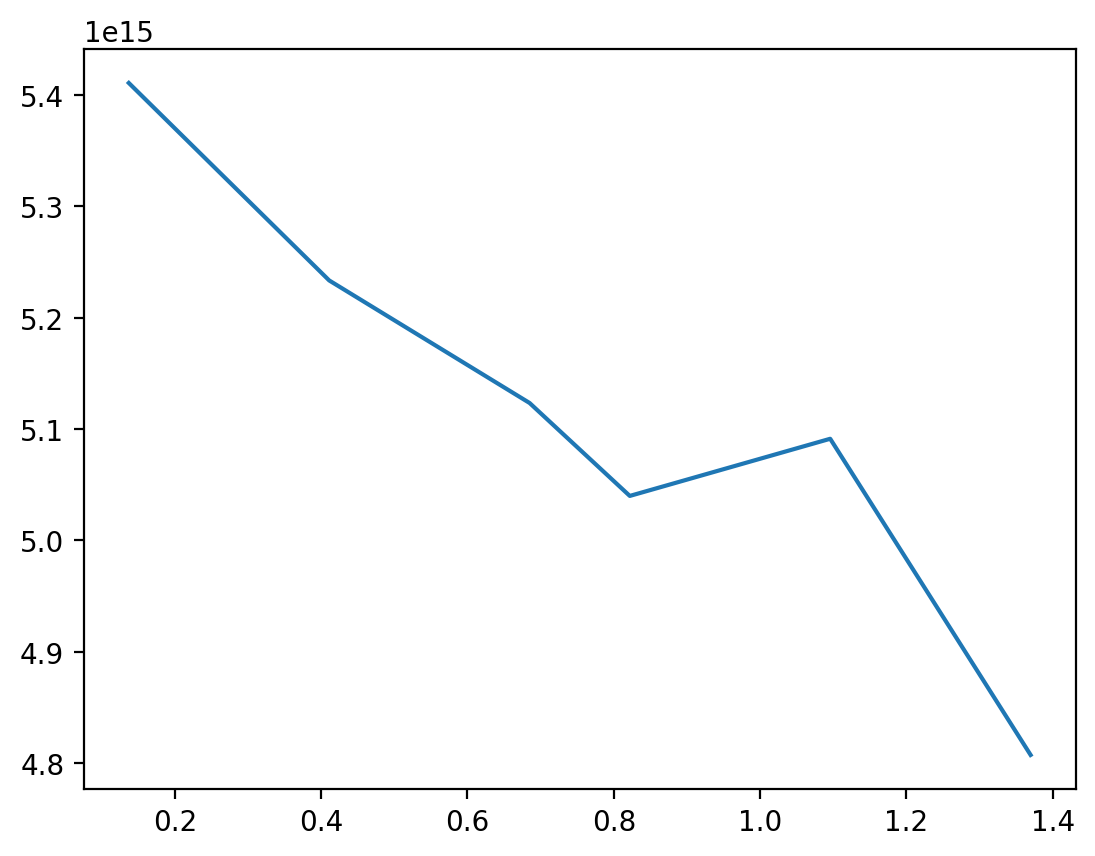

In [54]:
plt.plot(Deltat_y, [np.nanmean(s) for s in surface_list] )

In [62]:
Deltat = np.linspace(50, 50+565, 100) # days
Deltat_y = np.array(Deltat) * dtoy


new_xs_list = []
new_ys_list = []
surface_list = []

for ct in Deltat_y:
  deltass = np.linspace(0, 360, 500)
  new_xs, new_ys, surface = LE_xy_surface_concate(r0ly[2], ct, deltass, x)
  # plot(new_xs, new_ys, surface, deltass,  save = False, name = "name")

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  surface_list.append(surface)

new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

surface = np.concatenate(surface_list)


<ipython-input-10-1114441001c9>:18: RuntimeWarning: divide by zero encountered in divide
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:18: RuntimeWarning: invalid value encountered in sqrt
  y_inv1 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) - ct**2 - (x**2 * np.cos(np.deg2rad(delta))) + x**2) / (np.cos(np.deg2rad(delta))- 1))
<ipython-input-10-1114441001c9>:19: RuntimeWarning: invalid value encountered in sqrt
  y_inv2 = np.sqrt(((- (ct**2) * np.cos(np.deg2rad(delta))) + ct**2 - (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (np.cos(np.deg2rad(delta))+ 1))
<ipython-input-10-1114441001c9>:20: RuntimeWarning: divide by zero encountered in divide
  y_inv3 = -np.sqrt((((ct**2) * np.cos(np.deg2rad(delta))) + ct**2 + (x**2 * np.cos(np.deg2rad(delta))) - x**2) / (-(np.cos(np.deg2rad(delta))- 1)) )
<ipython-input-10-1114441001c9>:20: RuntimeWarning: invalid

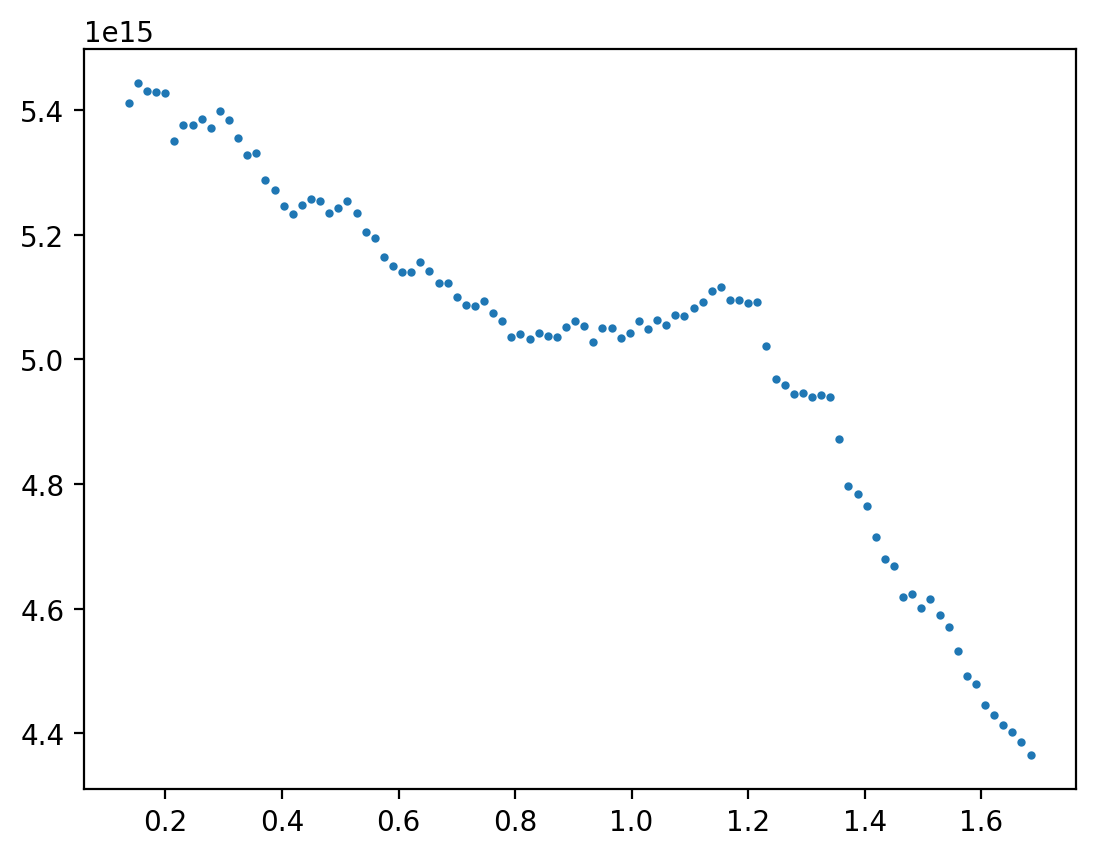

In [60]:
mean_sb = [np.nanmean(s) for s in surface_list]

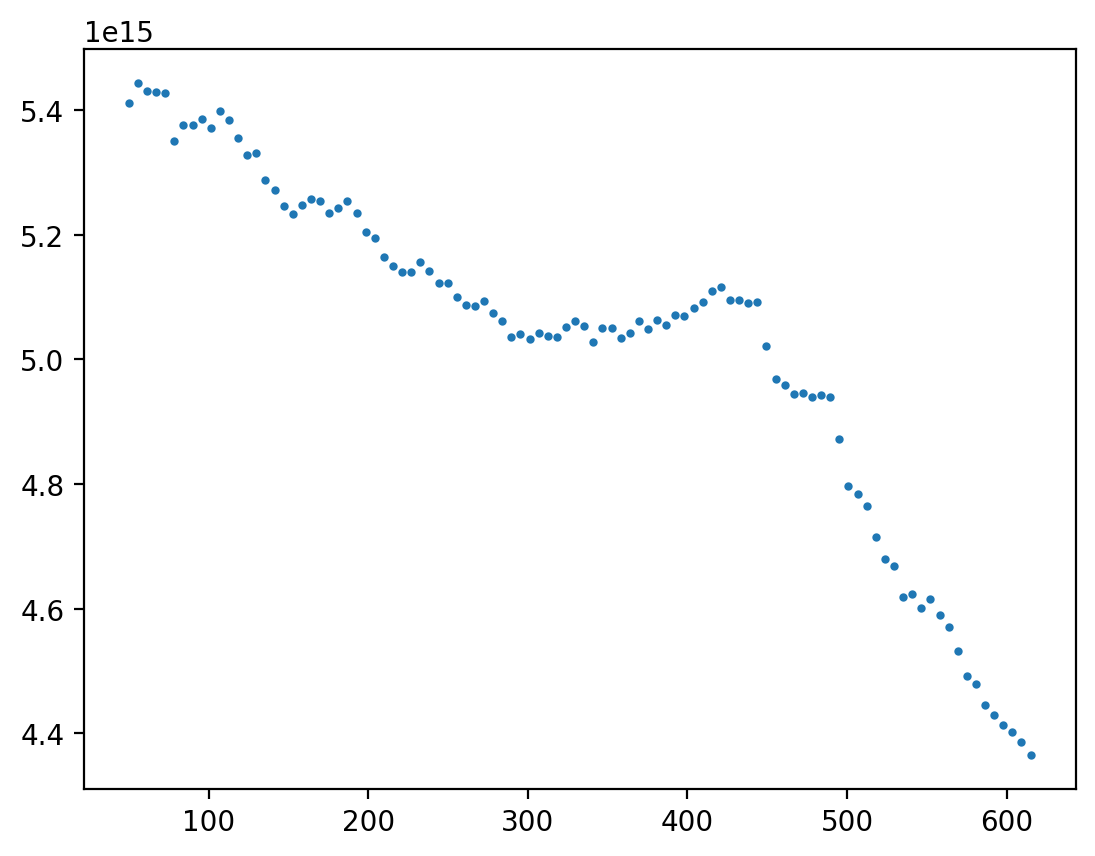

In [61]:
plt.scatter(Deltat_y / dtoy, mean_sb, s = 4)